In [343]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(rlang)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)
library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
library(ggplot2)
library(survminer)
library(muhaz)
library(dplyr)
library(stringr)
options(warn=-1)
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(broom)
library(logistf)
library(ggfortify)
source("../../src/tools.R")
source("../script_figures/tools.R")
library(DT)
# source("../src/tools.R")


In [344]:
df_cardiff <- read.table("../clustering/clustering_Final_1/df_final_full_component.tsv")
df_nejm <- read.table("../prognosis/Prognosis_locked/Validation/full_data_validation_NO_ITD.tsv")


In [345]:

val = c("#EE9937","#5C5C5C","#870C14","#BFBFBF","#59A08B","#2b8cbe","#a6bddb","#fdbb84","#e79f00","#000000","darkseagreen","lightskyblue","#0072B2","pink","blue","green")

df_w_correlates <- read.table("../clustering/clustering_Final_1/df_final_full_component.tsv")
df_final <- read.table("../clustering/clustering_Final_1/df_final_full_component.tsv")



cols_order <- c("t_15_17","inv_16","t_8_21","t_11","t_6_9","inv_3","additions","TP53_complex","NPM1","CEBPA_bi","DNMT3A_IDH1_2","WT1","chr_splicing_multiple","chr_splicing_1","not_assigned","no_events")

genes <- colnames(df_final[,c(5:88)])

cytos <- colnames(df_final[,c(89:158)])

eln <- colnames(df_final[,c(2,3,4)])
comp <- colnames(df_final[,c(170:186)])

all_gen <- c(5:88)
vect <- apply(X=df_final[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
gen <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])

all_cyto <- c(89:158)
vect <- apply(X=df_final[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
cyto <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])

clin <- colnames(df_final[,c(159:165)])
demo <- colnames(df_final[,c(166:167)])
pal <- c(eln="#EE9937",comp="#59A08B",gen="#BFBFBF",cyto="#2b8cbe",clin="#870C14",demo="#a6bddb",age="#a6bddb",gen_cyto="pink",eln_gen_cyto="#fdbb84",comp_gen_cyto="lightgoldenrod",all="lightsalmon")  
colors <- c("black","gray1","grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
"#9ad0f3", "#D55E00", 
"lightgoldenrod","lightskyblue","#F0E442",
"firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen","purple","forestgreen","gray2")
              
### Color Components ###
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))

color_values <- c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7","#9ad0f3", "#D55E00", "lightgoldenrod","lightskyblue","#F0E442",
                  "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen",
                  "purple","forestgreen")
tmp <- NULL
for (co in cols_component){
    tmp1 <- df_w_correlates[df_w_correlates[,co]==1,]
    tmp1$comparison <- str_remove(co,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }
tmp$fill_pal <- factor(tmp$comparison)
names(color_values) <- levels(factor(tmp$fill_pal))
color_values["overlap"] <- "purple"

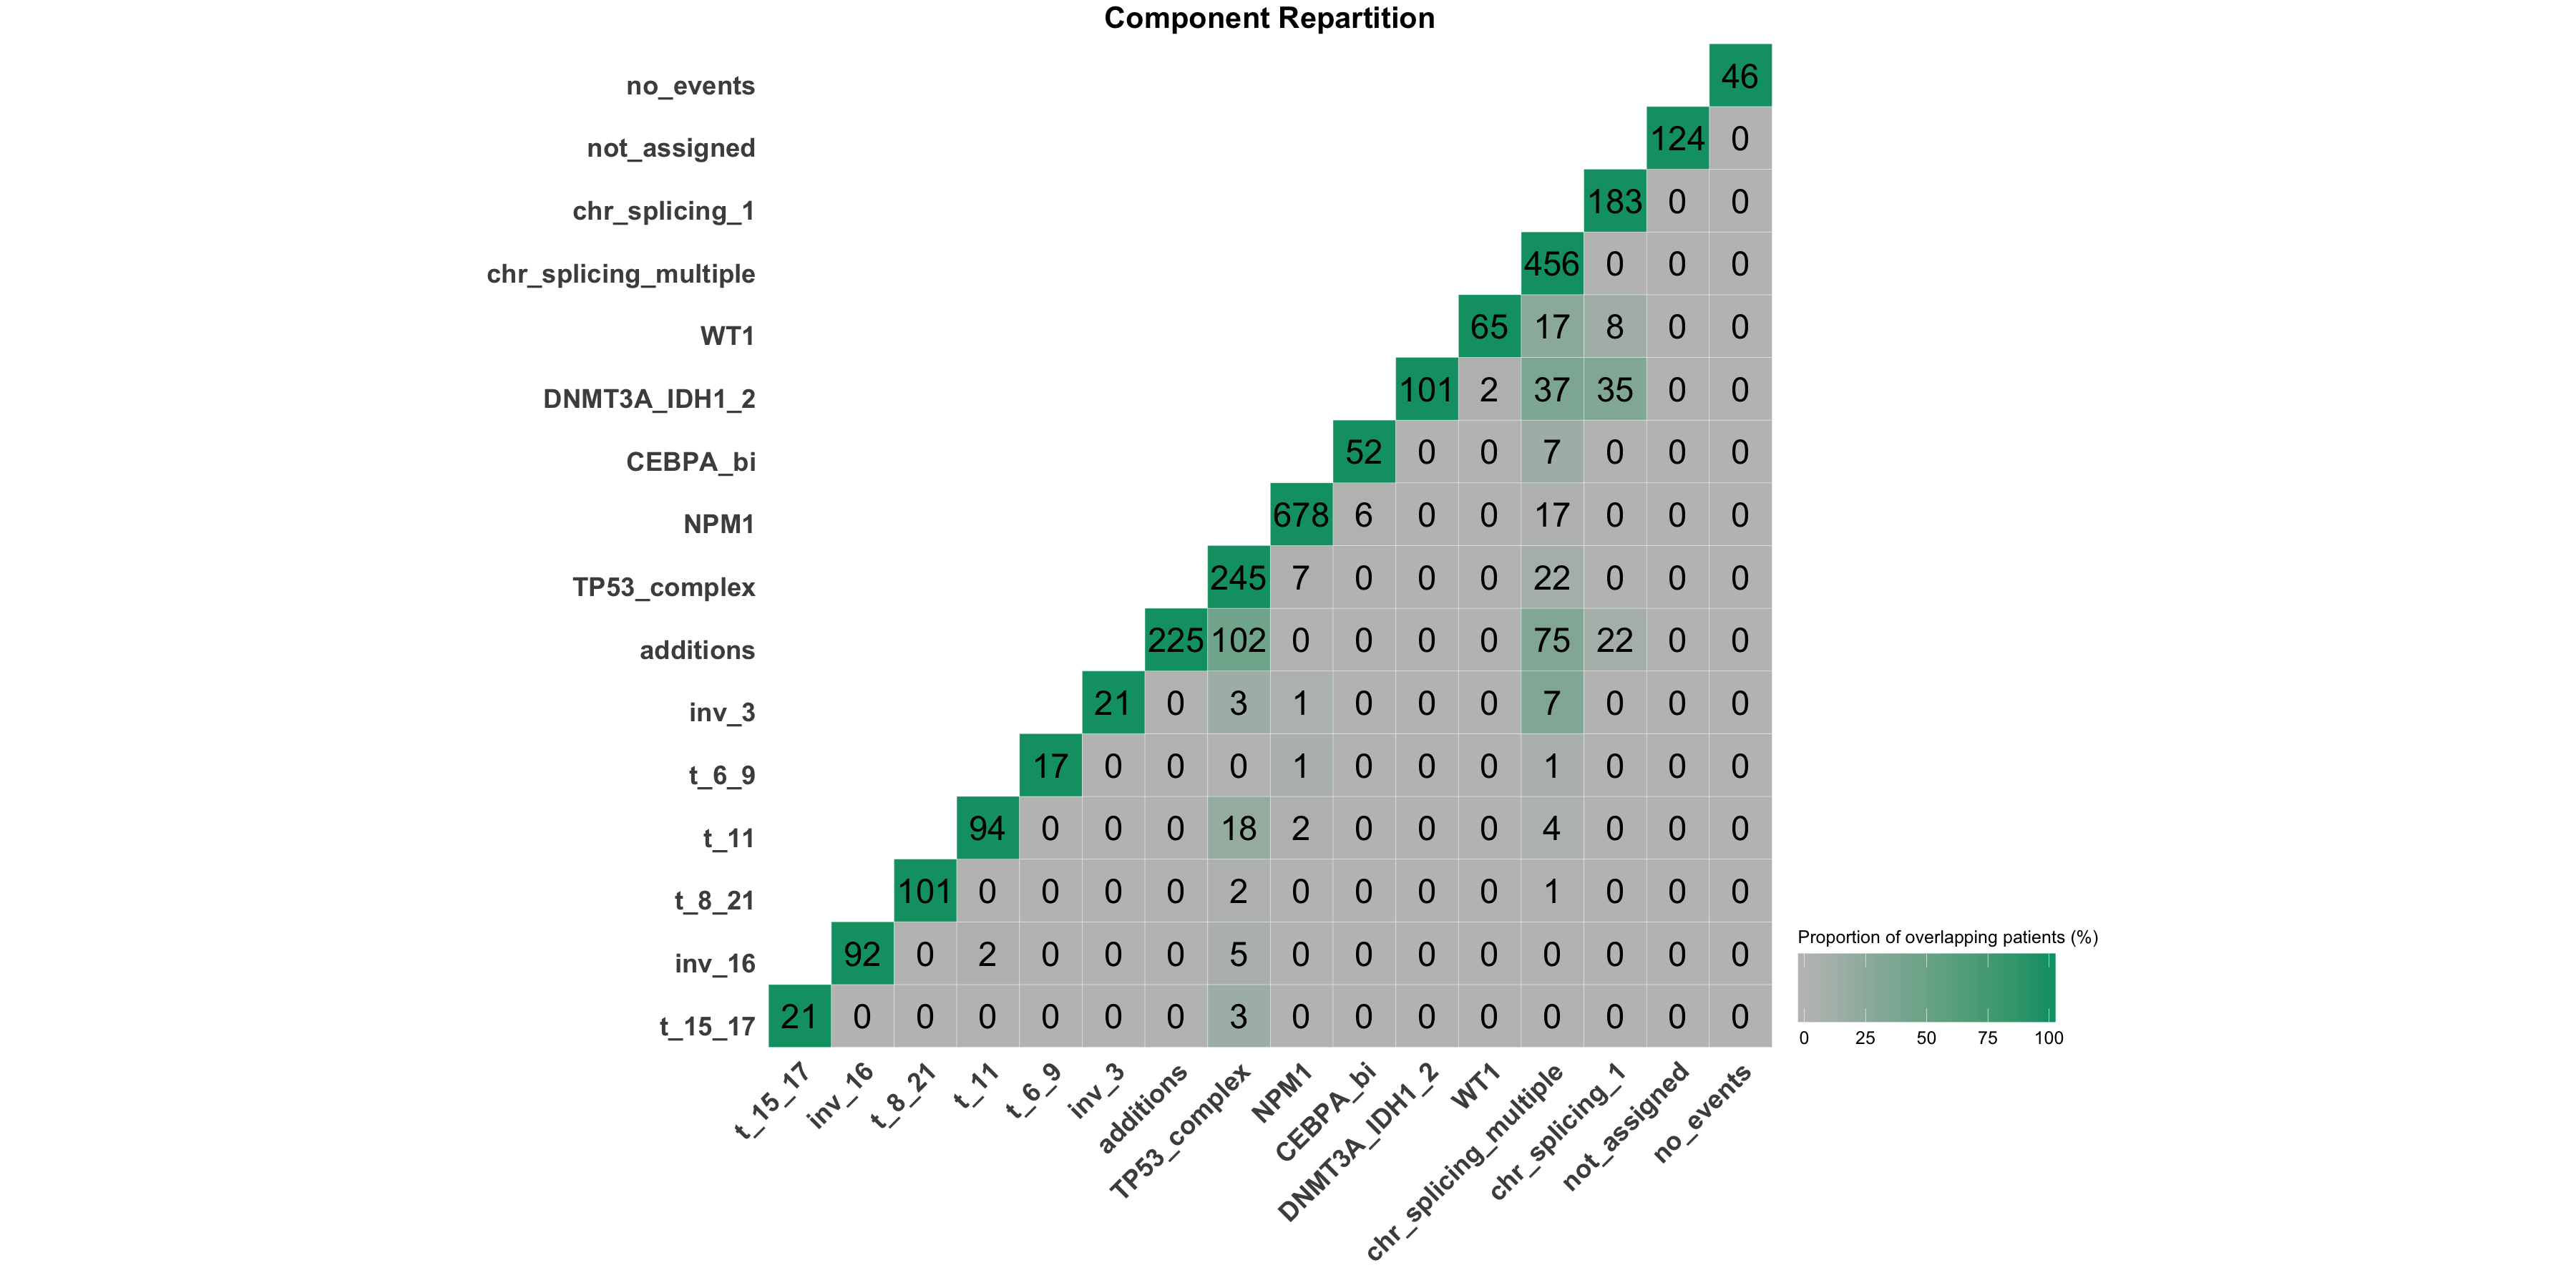

In [346]:
set_notebook_plot_size(30,15)
# png("figures/comp_repartition.png",width=5000,height=5000,res=250)
comp_repartition(df_final,cols_component,cols_order=cols_order)
# dev.off()

# Investigation additions

In [532]:
set_notebook_plot_size(10,5)
tmp <- df_w_correlates[df_w_correlates$full_component_additions==1 | df_w_correlates$full_component_chr_splicing_multiple==1,]

tmp$comparison <- ifelse(tmp$full_component_additions==1 & tmp$full_component_chr_splicing_multiple==1,"additions+chr_spl_mult",
                        ifelse(tmp$full_component_additions==1 & tmp$full_component_chr_splicing_multiple==0 & tmp$overlap==0,"additions_only",
                               ifelse(tmp$full_component_additions==0 & tmp$full_component_chr_splicing_multiple==1 & tmp$overlap==0,"chr_spl_mult_only","other_overlaps")))

tmp <- tmp[tmp$comparison!="other_overlaps" ,]

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
pval <- ifelse(pairwise_survdiff(Surv(os,os_status)~comparison,data = tmp[tmp$comparison %in% c("additions+chr_spl_mult","additions_only"),])$p.value[1] <1e-4,"<0.0001",
               round(pairwise_survdiff(Surv(os,os_status)~comparison,data = tmp[tmp$comparison %in% c("additions+chr_spl_mult","additions_only"),])$p.value[1],4))

pairwise_survdiff(Surv(os,os_status)~comparison,data = tmp[tmp$comparison %in% c("additions+chr_spl_mult","chr_spl_mult_only"),])$p.value[1]

p <- plot_surv_curves(fit,submain = "Cardiff Overlap splicing multiple",y="Survival Probability",font.legend=18,pval=paste("p_additions :",pval),pval.coord = c(3,0.9))



tmp <- df_w_correlates[df_w_correlates$full_component_additions==1 | df_w_correlates$full_component_TP53_complex==1,]

tmp$comparison <- ifelse(tmp$full_component_additions==1 & tmp$full_component_TP53_complex==1,"additions+TP53_complex",
                        ifelse(tmp$full_component_additions==1 & tmp$full_component_TP53_complex==0 & tmp$overlap==0,"additions_only",
                               ifelse(tmp$full_component_additions==0 & tmp$full_component_TP53_complex==1 & tmp$overlap==0,"TP53_complex_only","other_overlaps")))

tmp <- tmp[tmp$comparison!="other_overlaps" ,]

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
pval <- ifelse(pairwise_survdiff(Surv(os,os_status)~comparison,data = tmp[tmp$comparison %in% c("additions+TP53_complex","additions_only"),])$p.value[1] <1e-4,"<0.0001",
               round(pairwise_survdiff(Surv(os,os_status)~comparison,data = tmp[tmp$comparison %in% c("additions+TP53_complex","additions_only"),])$p.value[1],4))

pairwise_survdiff(Surv(os,os_status)~comparison,data = tmp[tmp$comparison %in% c("additions+TP53_complex","TP53_complex_only"),])$p.value[1]

q <- plot_surv_curves(fit,submain = "Cardiff Overlap TP53-Complex",y="",font.legend=18,pval=paste("p_additions :",pval),pval.coord = c(3,0.9))


tmp <- df_nejm[df_nejm$full_component_additions==1 | df_nejm$full_component_chr_splicing_multiple==1,]

tmp$comparison <- ifelse(tmp$full_component_additions==1 & tmp$full_component_chr_splicing_multiple==1,"additions+chr_spl_mult",
                        ifelse(tmp$full_component_additions==1 & tmp$full_component_chr_splicing_multiple==0 & tmp$overlap==0,"additions_only",
                               ifelse(tmp$full_component_additions==0 & tmp$full_component_chr_splicing_multiple==1 & tmp$overlap==0,"chr_spl_mult_only","other_overlaps")))

tmp <- tmp[tmp$comparison!="other_overlaps" ,]

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
pval <- ifelse(pairwise_survdiff(Surv(OS,OS_Status)~comparison,data = tmp[tmp$comparison %in% c("additions+chr_spl_mult","additions_only"),])$p.value[1] <1e-4,"<0.0001",
               round(pairwise_survdiff(Surv(OS,OS_Status)~comparison,data = tmp[tmp$comparison %in% c("additions+chr_spl_mult","additions_only"),])$p.value[1],4))

pairwise_survdiff(Surv(OS,OS_Status)~comparison,data = tmp[tmp$comparison %in% c("additions+chr_spl_mult","chr_spl_mult_only"),])$p.value[1]

r <- plot_surv_curves(fit,submain = "Nejm Overlap splicing multiple",y="Survival Probability",font.legend=18,pval=paste("p_additions :",pval),pval.coord = c(3,0.9))


tmp <- df_nejm[df_nejm$full_component_additions==1 | df_nejm$full_component_TP53_complex==1,]

tmp$comparison <- ifelse(tmp$full_component_additions==1 & tmp$full_component_TP53_complex==1,"additions+TP53_complex",
                        ifelse(tmp$full_component_additions==1 & tmp$full_component_TP53_complex==0 & tmp$overlap==0,"additions_only",
                               ifelse(tmp$full_component_additions==0 & tmp$full_component_TP53_complex==1 & tmp$overlap==0,"TP53_complex_only","other_overlaps")))

tmp <- tmp[tmp$comparison!="other_overlaps" ,]

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
pval <- ifelse(pairwise_survdiff(Surv(OS,OS_Status)~comparison,data = tmp[tmp$comparison %in% c("additions+TP53_complex","additions_only"),])$p.value[1] <1e-4,"<0.0001",
               round(pairwise_survdiff(Surv(OS,OS_Status)~comparison,data = tmp[tmp$comparison %in% c("additions+TP53_complex","additions_only"),])$p.value[1],4))

pairwise_survdiff(Surv(OS,OS_Status)~comparison,data = tmp[tmp$comparison %in% c("additions+TP53_complex","TP53_complex_only"),])$p.value[1]

s <- plot_surv_curves(fit,submain = "Nejm Overlap TP53-Complex",y="",font.legend=18,pval=paste("p_additions :",pval),pval.coord = c(3,0.9))

png("figures/additions_justification.png",width=2400,height=1000,res=100)
grid.arrange(p$plot,q$plot,r$plot,s$plot,nrow=2)
dev.off()


[1] 0.0004436816

[1] 0.009562145

[1] 0.005917321

[1] 0.06979416

pdf 
  2

# Investigation Bi allelic CEBPA

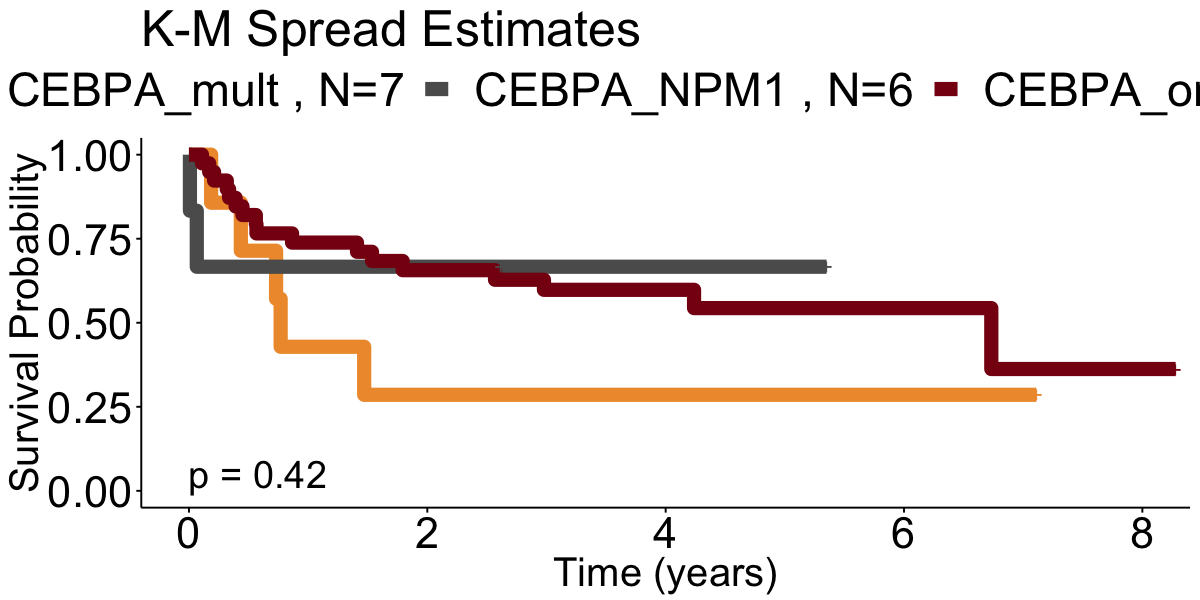

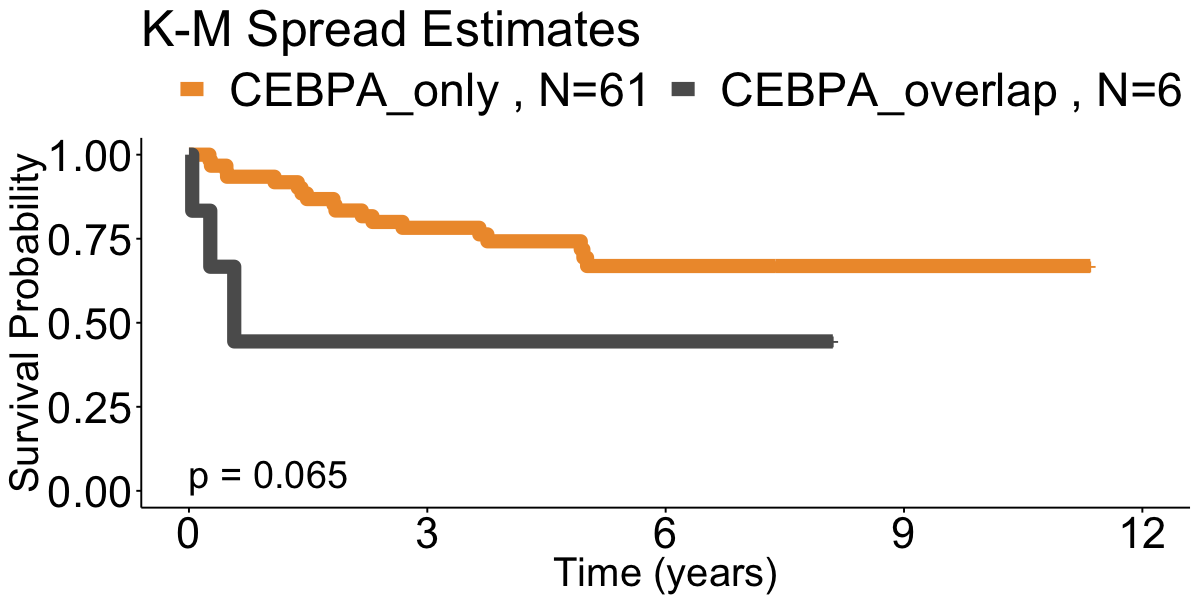

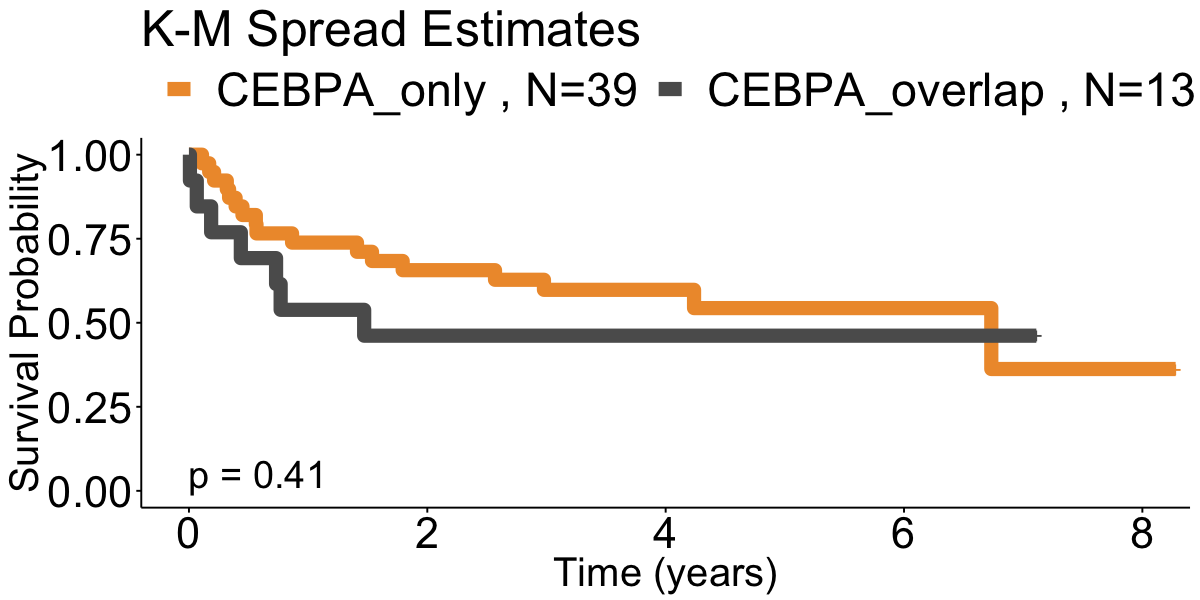

In [348]:
tmp <- df_w_correlates[df_w_correlates$full_component_CEBPA_bi==1,]

tmp$comparison <- ifelse(tmp$full_component_CEBPA_bi==1 & tmp$full_component_chr_splicing_multiple,"CEBPA_mult",
                        ifelse(tmp$full_component_CEBPA_bi==1 & tmp$NPM1==1,"CEBPA_NPM1",
                               ifelse(tmp$full_component_CEBPA_bi==1 & tmp$overlap==0,"CEBPA_only","others")))


surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,submain = "K-M Spread Estimates",y="Survival Probability")
p

tmp <- df_nejm[df_nejm$full_component_CEBPA_bi==1,]

tmp$comparison <- ifelse(tmp$full_component_CEBPA_bi==1 & tmp$overlap==1,"CEBPA_overlap",
                               ifelse(tmp$full_component_CEBPA_bi==1 & tmp$overlap==0,"CEBPA_only","others"))


surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,submain = "K-M Spread Estimates",y="Survival Probability")
p
tmp <- df_w_correlates[df_w_correlates$full_component_CEBPA_bi==1,]

tmp$comparison <- ifelse(tmp$full_component_CEBPA_bi==1 & tmp$overlap==1,"CEBPA_overlap",
                               ifelse(tmp$full_component_CEBPA_bi==1 & tmp$overlap==0,"CEBPA_only","others"))


surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,submain = "K-M Spread Estimates",y="Survival Probability")
p


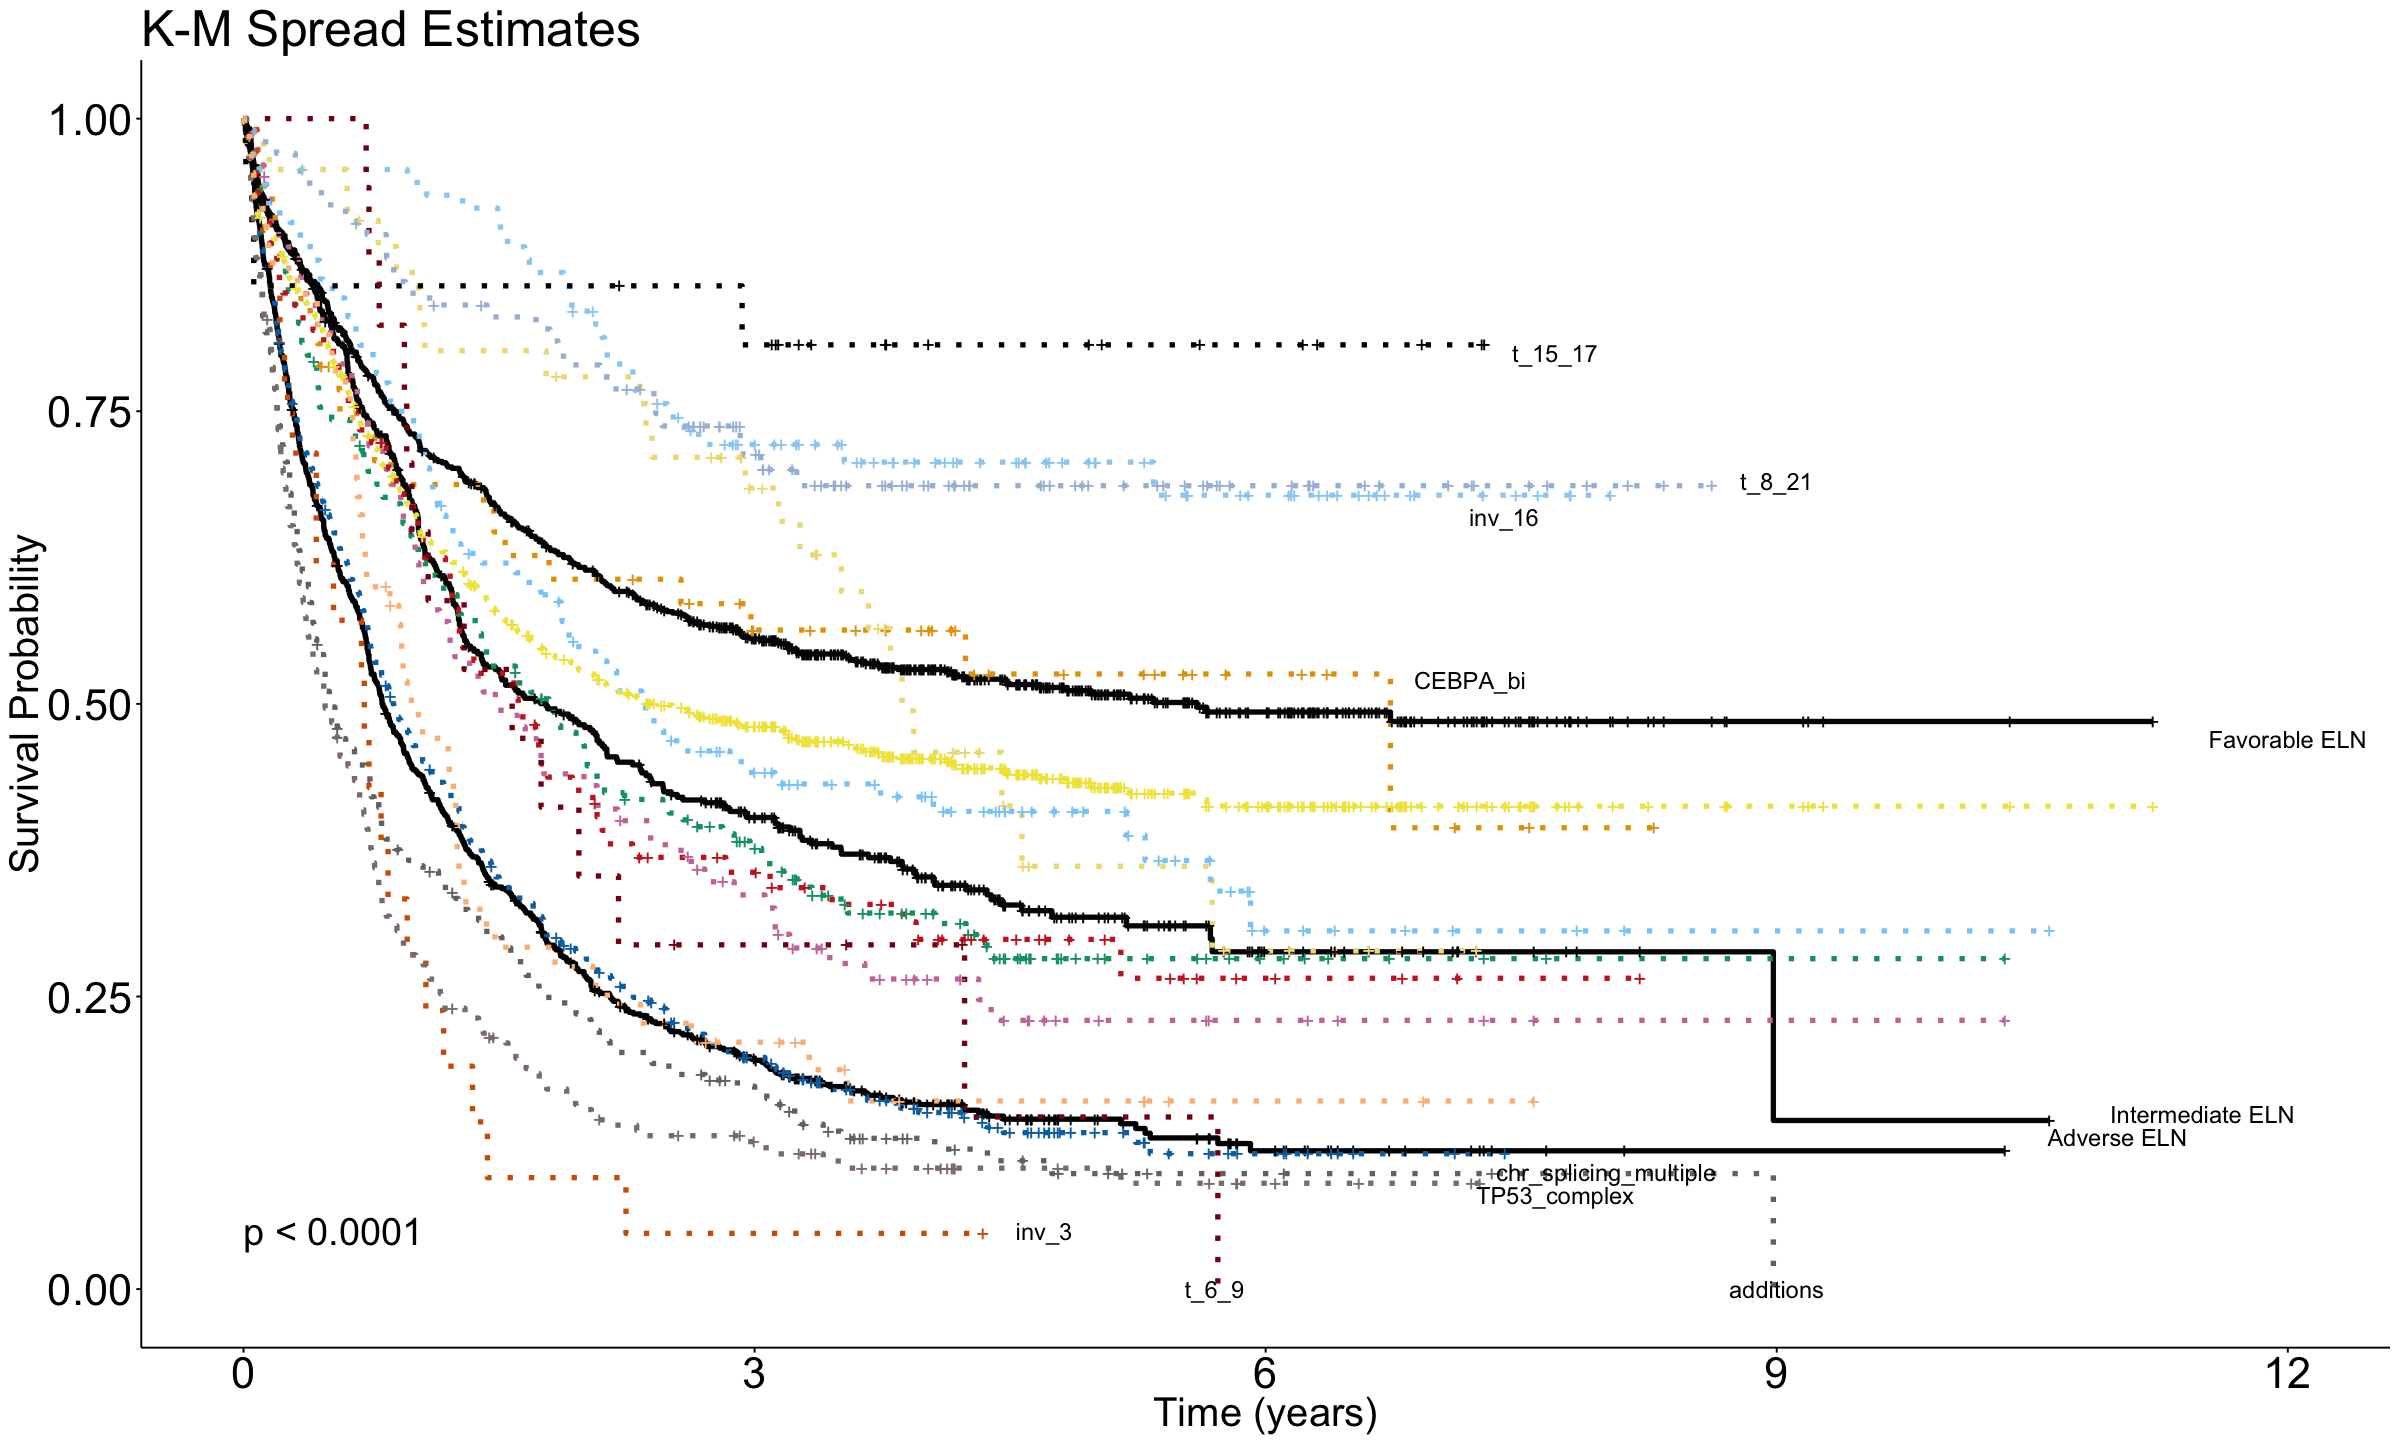

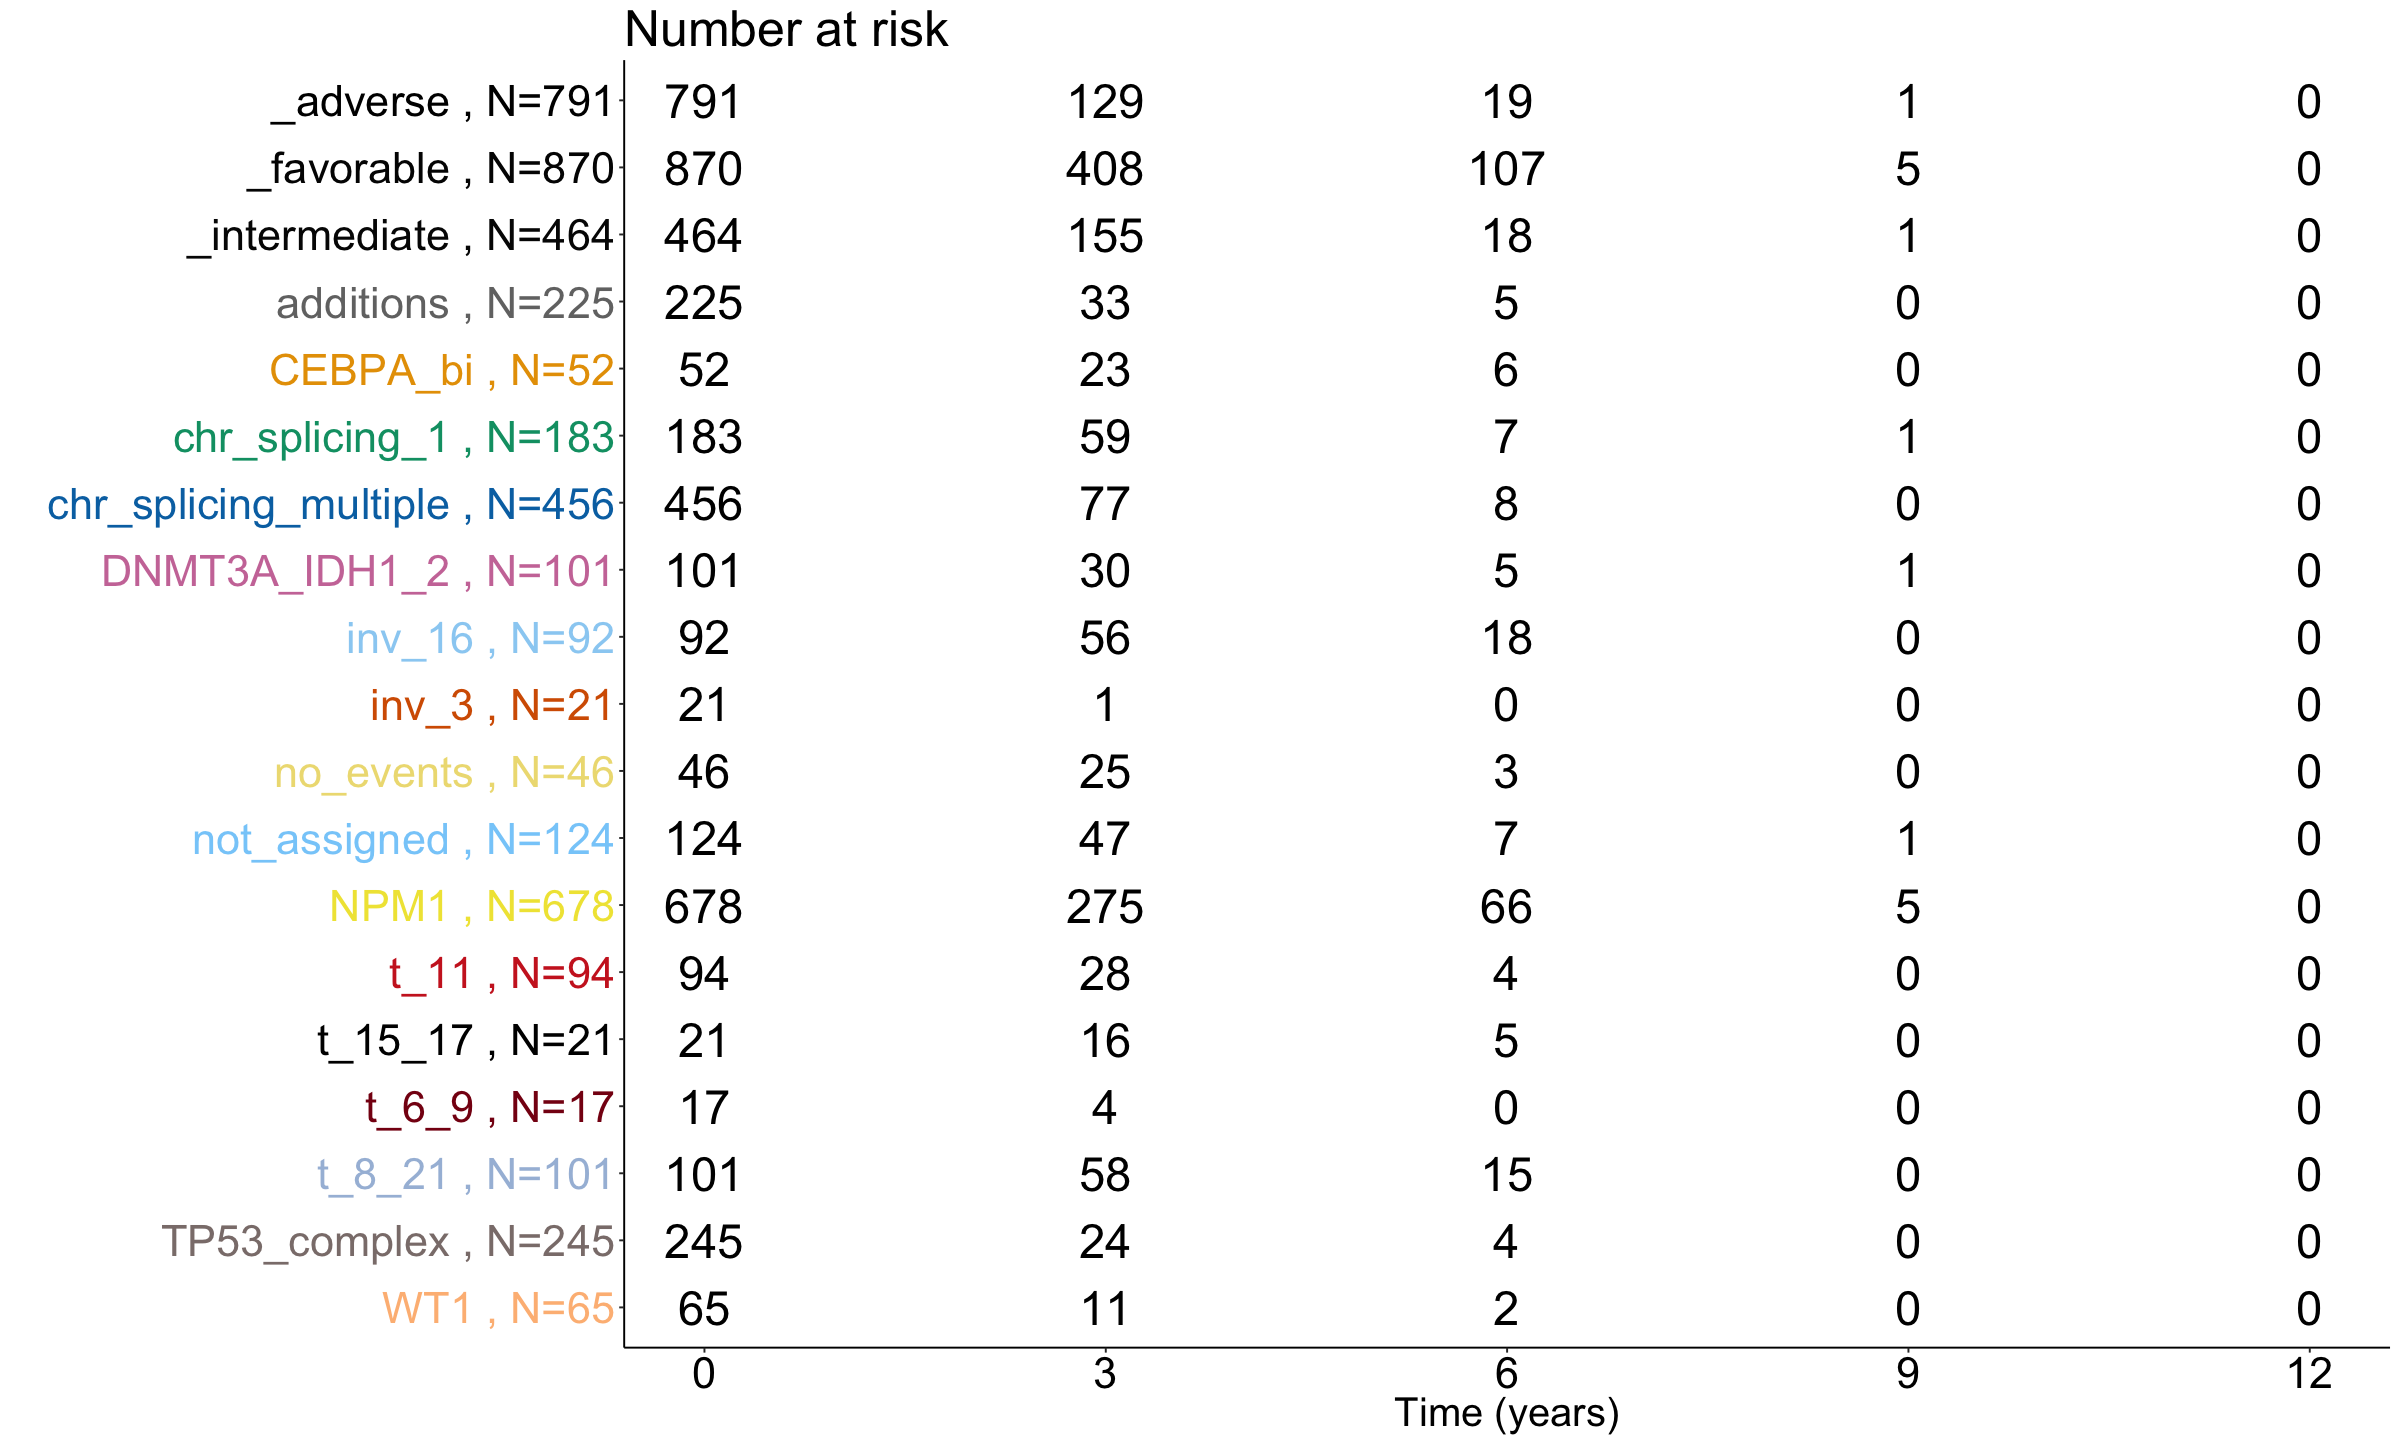

In [349]:
colors <- c("black","gray1","gray2",as.vector(unlist(color_values)))

tmp <- NULL
for (col in cols_component){
    tmp1 <- df_w_correlates[df_w_correlates[,col]==1,]
    tmp1$comparison <- str_remove(col,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }

tmp1 <- df_final

tmp1$comparison <- ifelse(tmp1$eln_2017==1,"_adverse",
                          ifelse(tmp1$eln_2017==2,"_intermediate","_favorable"))
                          
tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,submain = "K-M Spread Estimates",vals=colors,linetype=c(1,1,1,rep(3,16)),size=1.5,y="Survival Probability",legend="none",risk.tab=T)


set_notebook_plot_size(20,12)

# png("figures/spread_surv_plot.png",width=5500,height=4500,res=350)
p$plot + ggplot2::annotate("text", 
                                x = c(4.7,5.7,7.7,9,8,11,11.5,12,7.2,7.4,9,7.7), y = c(0.05,0,0.08,0,0.1,0.13,0.15,0.47,0.52,0.66,0.69,0.8),
                                label = c("inv_3","t_6_9","TP53_complex","additions","chr_splicing_multiple","Adverse ELN","Intermediate ELN",
                                          "Favorable ELN","CEBPA_bi","inv_16","t_8_21","t_15_17"), size = 5)

p$table

In [350]:
plot_surv_curves

function (fit, submain = "", vals = val, legend = "top", risk.tab = F, 
    y = "", linetype = 1, size = 4, pval = TRUE, pval.coord = c(0, 
        0.05), font.legend = 28, xlab = "Time (years)", legend.title = "", 
    ...) 
{
    vec <- NULL
    for (i in 1:length(fit$strata)) {
        vec <- cbind(vec, paste(str_remove(names(fit$strata[i]), 
            "comparison="), fit$n[i], sep = " , N="))
    }
    ggsurvplot(fit, pval = pval, main = "Survival curve", risk.table = risk.tab, 
        submain = submain, palette = vals, legend = legend, pval.size = 8, 
        pval.coord = pval.coord, risk.table.fontsize = 10, xlab = xlab, 
        legend.labs = vec, ylab = y, legend.title = legend.title, 
        ..., linetype = linetype, size = size, ggtheme = theme_survminer(font.main = c(30, 
            "plain", "black"), font.submain = c(30, "plain", 
            "black"), font.legend = font.legend, font.caption = c(30, 
            "plain", "black"), font.x = c(24, "plain", "black"), 
            font.y = c(24, "plain", "black"), font.tickslab = c(26, 
                "plain", "black")))
}
<bytecode: 0x7fc6753dc960>

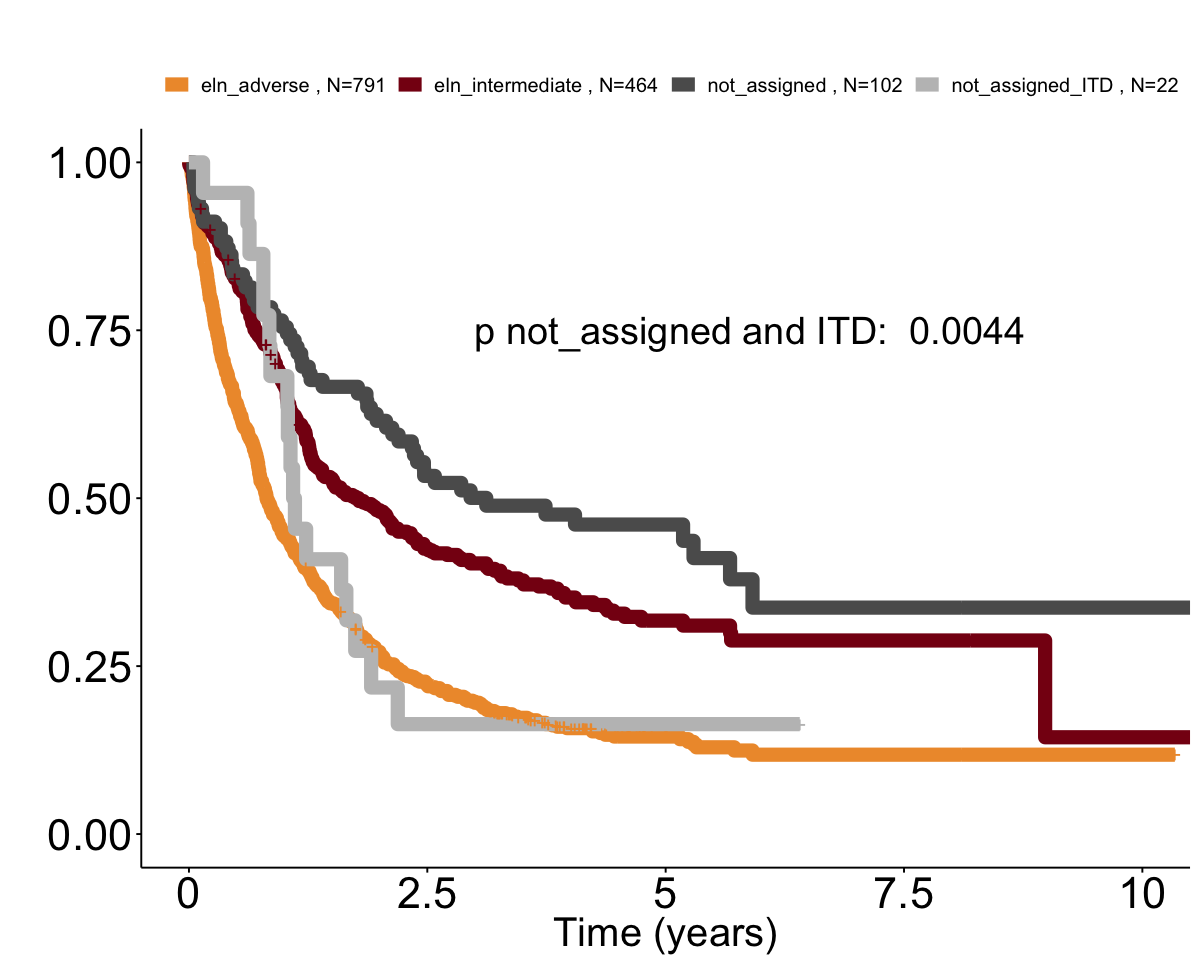

In [529]:
set_notebook_plot_size(10,8)

tmp <- df_final[df_final$full_component_not_assigned==1,]
tmp$comparison <- ifelse(tmp$full_component_not_assigned==1 & tmp$ITD==1,"not_assigned_ITD",
                     ifelse(tmp$full_component_not_assigned==1,"not_assigned","others"))



tmp1 <- df_final[df_final$eln_2017<3,]

tmp1$comparison <- ifelse(tmp1$eln_2017==1,"eln_adverse",
                          ifelse(tmp1$eln_2017==2,"eln_intermediate","_favorable"))
                          
tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)

pval <- ifelse(pairwise_survdiff(Surv(os,os_status)~comparison,data = tmp[tmp$comparison %in% c("not_assigned","not_assigned_ITD"),])$p.value[1] <1e-4,"<0.0001",
               round(pairwise_survdiff(Surv(os,os_status)~comparison,data = tmp[tmp$comparison %in% c("not_assigned","not_assigned_ITD"),])$p.value[1],4))

plot_surv_curves(fit,font.legend=12,pval=paste("p not_assigned and ITD: ",pval),pval.coord=c(3,0.75),vals=c('#EE9937','#870C14','#5C5C5C','#BFBFBF'))



# NEW MOLECULAR CLASSIFICATION

In [352]:
df_final$molecular_classification <- "none"

df_final[(df_final$full_component_NPM1==1 |df_final$full_component_inv_16==1 | df_final$full_component_t_8_21==1 | df_final$full_component_t_15_17==1 ) & df_final$molecular_classification=="none","molecular_classification"] <- "favorable"

df_final[(df_final$full_component_chr_splicing_1==1 | df_final$full_component_t_6_9==1) & df_final$molecular_classification=="none" ,"molecular_classification"] <- "intermediate"
          
df_final[((df_final$full_component_additions==1 & df_final$overlap==1) | df_final$full_component_chr_splicing_multiple==1 | 
          df_final$full_component_TP53_complex==1   | df_final$full_component_inv_3==1) & df_final$molecular_classification=="none","molecular_classification"] <- "adverse"  
          
df_final[((df_final$full_component_additions==1 & df_final$overlap==0) | df_final$full_component_t_11==1 | df_final$full_component_WT1==1 | df_final$full_component_DNMT3A_IDH1_2==1 |
          df_final$full_component_not_assigned==1) & df_final$molecular_classification=="none","molecular_classification"] <- "intermediate"
          
df_final[(df_final$full_component_CEBPA_bi==1 | df_final$full_component_no_events==1) & df_final$molecular_classification=="none" ,"molecular_classification"] <- "favorable"

#order is important! adverse . then intermediate otherwise we . overlap
# df_final[df_final$molecular_classification=="intermediate" & df_final$ITD==1,"molecular_classification"] <- "adverse"

# df_final[df_final$molecular_classification=="favorable" & df_final$ITD==1,"molecular_classification"] <- "intermediate"



In [353]:
df_nejm$molecular_classification <- "none"

df_nejm[(df_nejm$full_component_NPM1==1 |df_nejm$full_component_inv_16==1 | df_nejm$full_component_t_8_21==1 | df_nejm$full_component_t_15_17==1 ) & df_nejm$molecular_classification=="none","molecular_classification"] <- "favorable"

df_nejm[(df_nejm$full_component_chr_splicing_1==1 | df_nejm$full_component_t_6_9==1) & df_nejm$molecular_classification=="none" ,"molecular_classification"] <- "intermediate"
          
df_nejm[((df_nejm$full_component_additions==1 & df_nejm$overlap==1) | df_nejm$full_component_chr_splicing_multiple==1 | 
          df_nejm$full_component_TP53_complex==1   | df_nejm$full_component_inv_3==1) & df_nejm$molecular_classification=="none","molecular_classification"] <- "adverse"  
          
df_nejm[((df_nejm$full_component_additions==1 & df_nejm$overlap==0) | df_nejm$full_component_t_11==1 | df_nejm$full_component_WT1==1 | df_nejm$full_component_DNMT3A_IDH1_2==1 |
          df_nejm$full_component_not_assigned==1) & df_nejm$molecular_classification=="none","molecular_classification"] <- "intermediate"
          
df_nejm[(df_nejm$full_component_CEBPA_bi==1 | df_nejm$full_component_no_events==1) & df_nejm$molecular_classification=="none" ,"molecular_classification"] <- "favorable"


#order is important! adverse . then intermediate otherwise we . overlap
# df_nejm[df_nejm$molecular_classification=="intermediate" & df_nejm$ITD==1,"molecular_classification"] <- "adverse"

# df_nejm[df_nejm$molecular_classification=="favorable" & df_nejm$ITD==1,"molecular_classification"] <- "intermediate"

# ITD : increase the risk from Favorable to Intermediate and From Intermediate to Poor

In [354]:
plist_cardiff <- list()
for (risk_strat in c("favorable","intermediate","adverse")){
    tmp <- df_final[df_final$molecular_classification==risk_strat,]
    tmp$comparison <-ifelse(tmp$ITD==1,"ITD mut","ITD wt")
    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    plist_cardiff[[risk_strat]] <- plot_surv_curves(fit,font.legend = 24,y=ifelse(risk_strat=="favorable","Survival Probability",""),font.submain=40,submain = paste(risk_strat,"Cardiff"))$plot
}

plist_nejm <- list()
for (risk_strat in c("favorable","intermediate","adverse")){
    tmp <- df_nejm[df_nejm$molecular_classification==risk_strat,]
    tmp$comparison <-ifelse(tmp$ITD==1,"ITD mut","ITD wt")
    surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    plist_nejm[[risk_strat]] <- plot_surv_curves(fit,font.legend = 24,y=ifelse(risk_strat=="favorable","Survival Probability",""),font.submain=40,submain = paste(risk_strat,"Nejm"),risk.tab=F)$plot
}

png("figures/ITD_just.png",width=3000,height=2000,res=100)
do.call("grid.arrange",c(plist_cardiff,plist_nejm,nrow=2))
dev.off()

pdf 
  2

# Risk Stratification : Final version with ITD

In [355]:
table(df_final$molecular_classification)


     adverse    favorable intermediate 
         655          977          493 

In [356]:
df_final$molecular_classification <- "none"

df_final[(df_final$full_component_NPM1==1 |df_final$full_component_inv_16==1 | df_final$full_component_t_8_21==1 | df_final$full_component_t_15_17==1 ) & df_final$molecular_classification=="none","molecular_classification"] <- "favorable"

df_final[(df_final$full_component_chr_splicing_1==1 | df_final$full_component_t_6_9==1) & df_final$molecular_classification=="none" ,"molecular_classification"] <- "intermediate"
          
df_final[((df_final$full_component_additions==1 & df_final$overlap==1) | df_final$full_component_chr_splicing_multiple==1 | 
          df_final$full_component_TP53_complex==1   | df_final$full_component_inv_3==1) & df_final$molecular_classification=="none","molecular_classification"] <- "adverse"  
          
df_final[((df_final$full_component_additions==1 & df_final$overlap==0) | df_final$full_component_t_11==1 | df_final$full_component_WT1==1 | df_final$full_component_DNMT3A_IDH1_2==1 |
          df_final$full_component_not_assigned==1) & df_final$molecular_classification=="none","molecular_classification"] <- "intermediate"
          
df_final[(df_final$full_component_CEBPA_bi==1 | df_final$full_component_no_events==1) & df_final$molecular_classification=="none" ,"molecular_classification"] <- "favorable"

#order is important! adverse . then intermediate otherwise we . overlap
df_final[df_final$molecular_classification=="intermediate" & df_final$ITD==1,"molecular_classification"] <- "adverse"

df_final[df_final$molecular_classification=="favorable" & df_final$ITD==1,"molecular_classification"] <- "intermediate"



In [357]:
df_nejm$molecular_classification <- "none"

df_nejm[(df_nejm$full_component_NPM1==1 |df_nejm$full_component_inv_16==1 | df_nejm$full_component_t_8_21==1 | df_nejm$full_component_t_15_17==1 ) & df_nejm$molecular_classification=="none","molecular_classification"] <- "favorable"

df_nejm[(df_nejm$full_component_chr_splicing_1==1 | df_nejm$full_component_t_6_9==1) & df_nejm$molecular_classification=="none" ,"molecular_classification"] <- "intermediate"
          
df_nejm[((df_nejm$full_component_additions==1 & df_nejm$overlap==1) | df_nejm$full_component_chr_splicing_multiple==1 | 
          df_nejm$full_component_TP53_complex==1   | df_nejm$full_component_inv_3==1) & df_nejm$molecular_classification=="none","molecular_classification"] <- "adverse"  
          
df_nejm[((df_nejm$full_component_additions==1 & df_nejm$overlap==0) | df_nejm$full_component_t_11==1 | df_nejm$full_component_WT1==1 | df_nejm$full_component_DNMT3A_IDH1_2==1 |
          df_nejm$full_component_not_assigned==1) & df_nejm$molecular_classification=="none","molecular_classification"] <- "intermediate"
          
df_nejm[(df_nejm$full_component_CEBPA_bi==1 | df_nejm$full_component_no_events==1) & df_nejm$molecular_classification=="none" ,"molecular_classification"] <- "favorable"


#order is important! adverse . then intermediate otherwise we . overlap
df_nejm[df_nejm$molecular_classification=="intermediate" & df_nejm$ITD==1,"molecular_classification"] <- "adverse"

df_nejm[df_nejm$molecular_classification=="favorable" & df_nejm$ITD==1,"molecular_classification"] <- "intermediate"

In [358]:
table(df_final$molecular_classification)


     adverse    favorable intermediate 
         752          689          684 

# End of Molecular Classification

In [359]:
tmp <- df_final
tmp$comparison <- paste("NEW_",tmp$molecular_classification,sep="")


tmp1 <- df_final

tmp1$comparison <- ifelse(tmp1$eln_2017==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017==2,"ELN_intermediate","ELN_favorable"))
                          
tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,risk.tab = T,linetype=c(3,3,3,1,1,1),font.legend = 18,y="Survival Probability",submain = "Cardiff Data")

tmp <- df_nejm
tmp$comparison <- paste("NEW_",tmp$molecular_classification,sep="")


tmp1 <- df_nejm

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_favorable"))
                          
tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,risk.tab = T,xlim=c(0,12),break.time.by=3,linetype=c(3,3,3,1,1,1),font.legend = 18,submain = "Nejm Data")

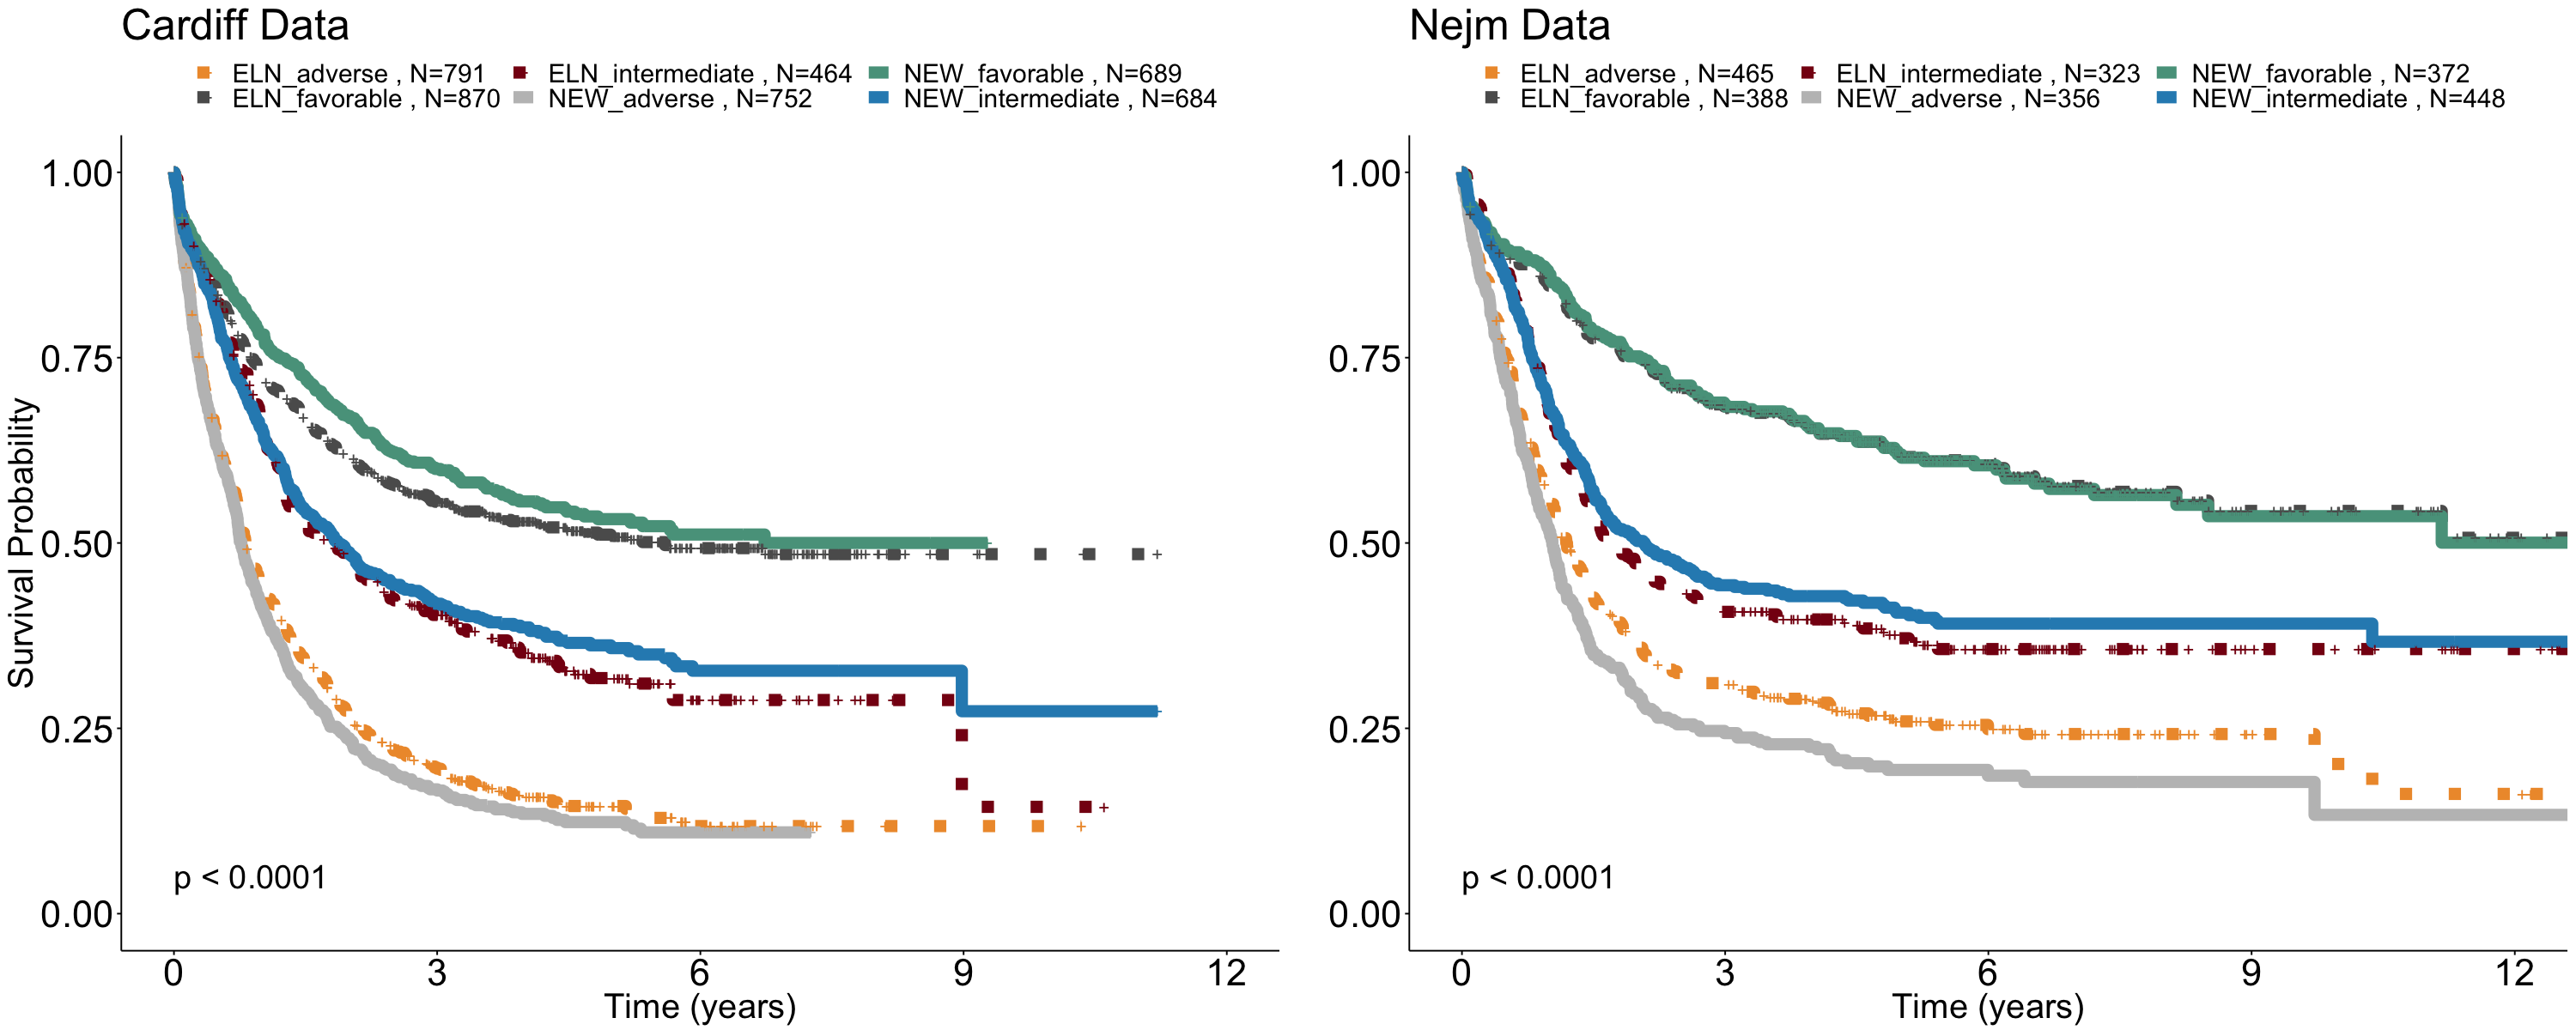

In [360]:
set_notebook_plot_size(25,10)
grid.arrange(p$plot,q$plot,nrow=1)

# Intersection Validation

# Favorable

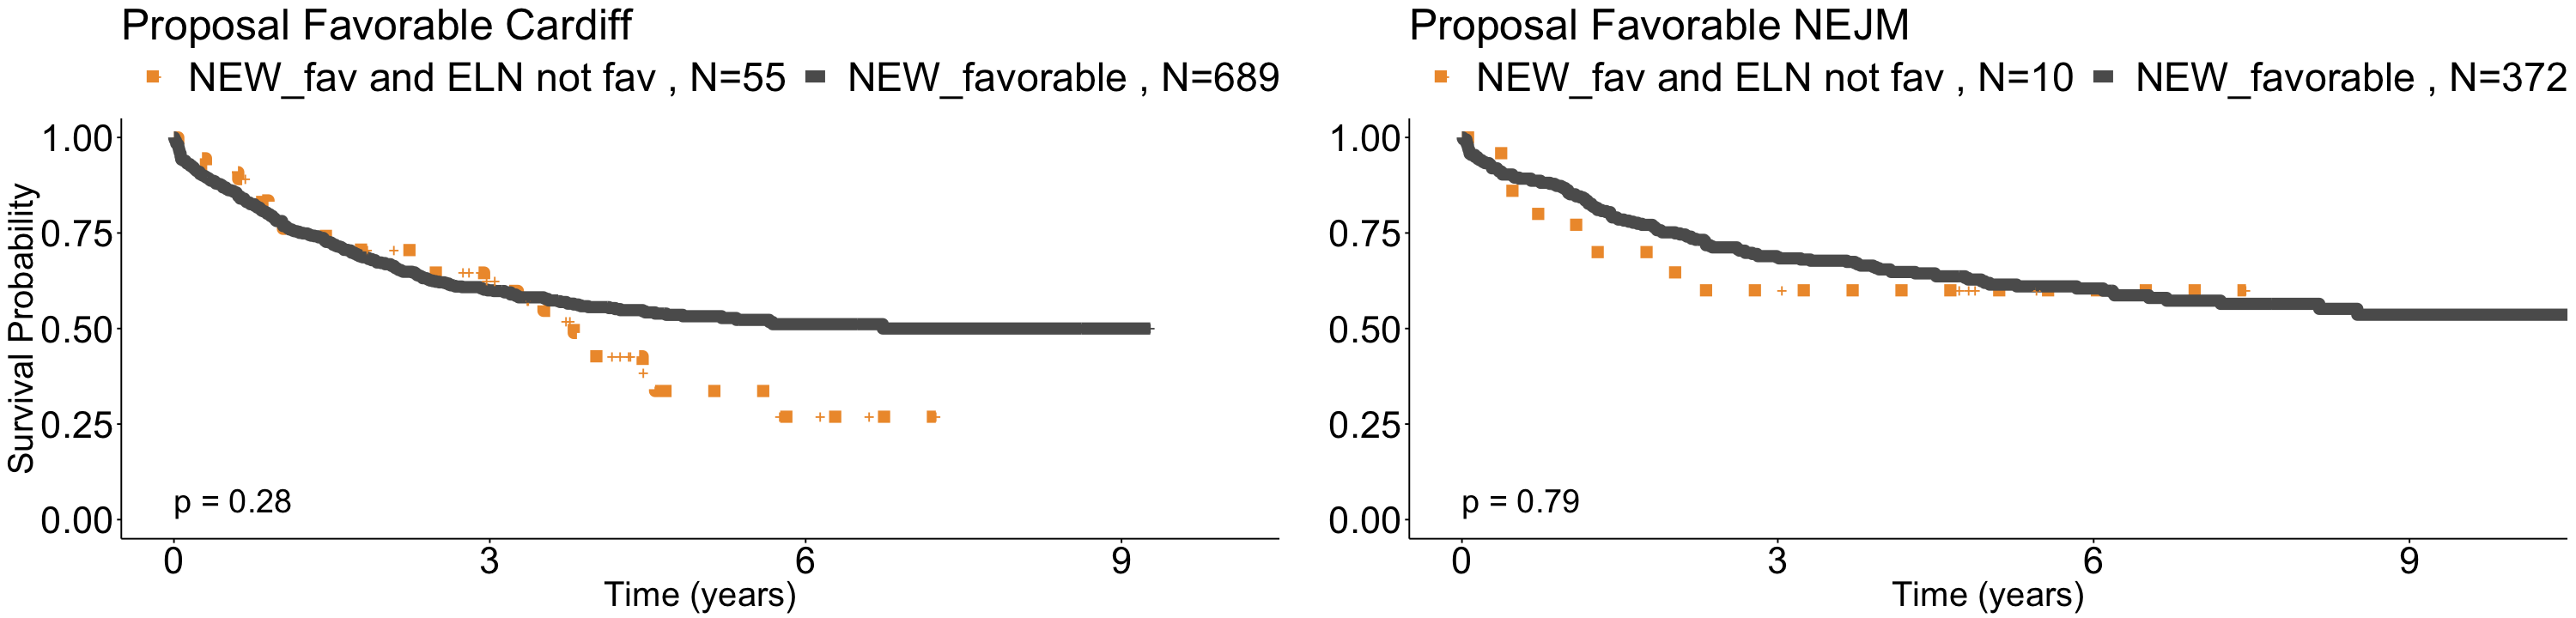

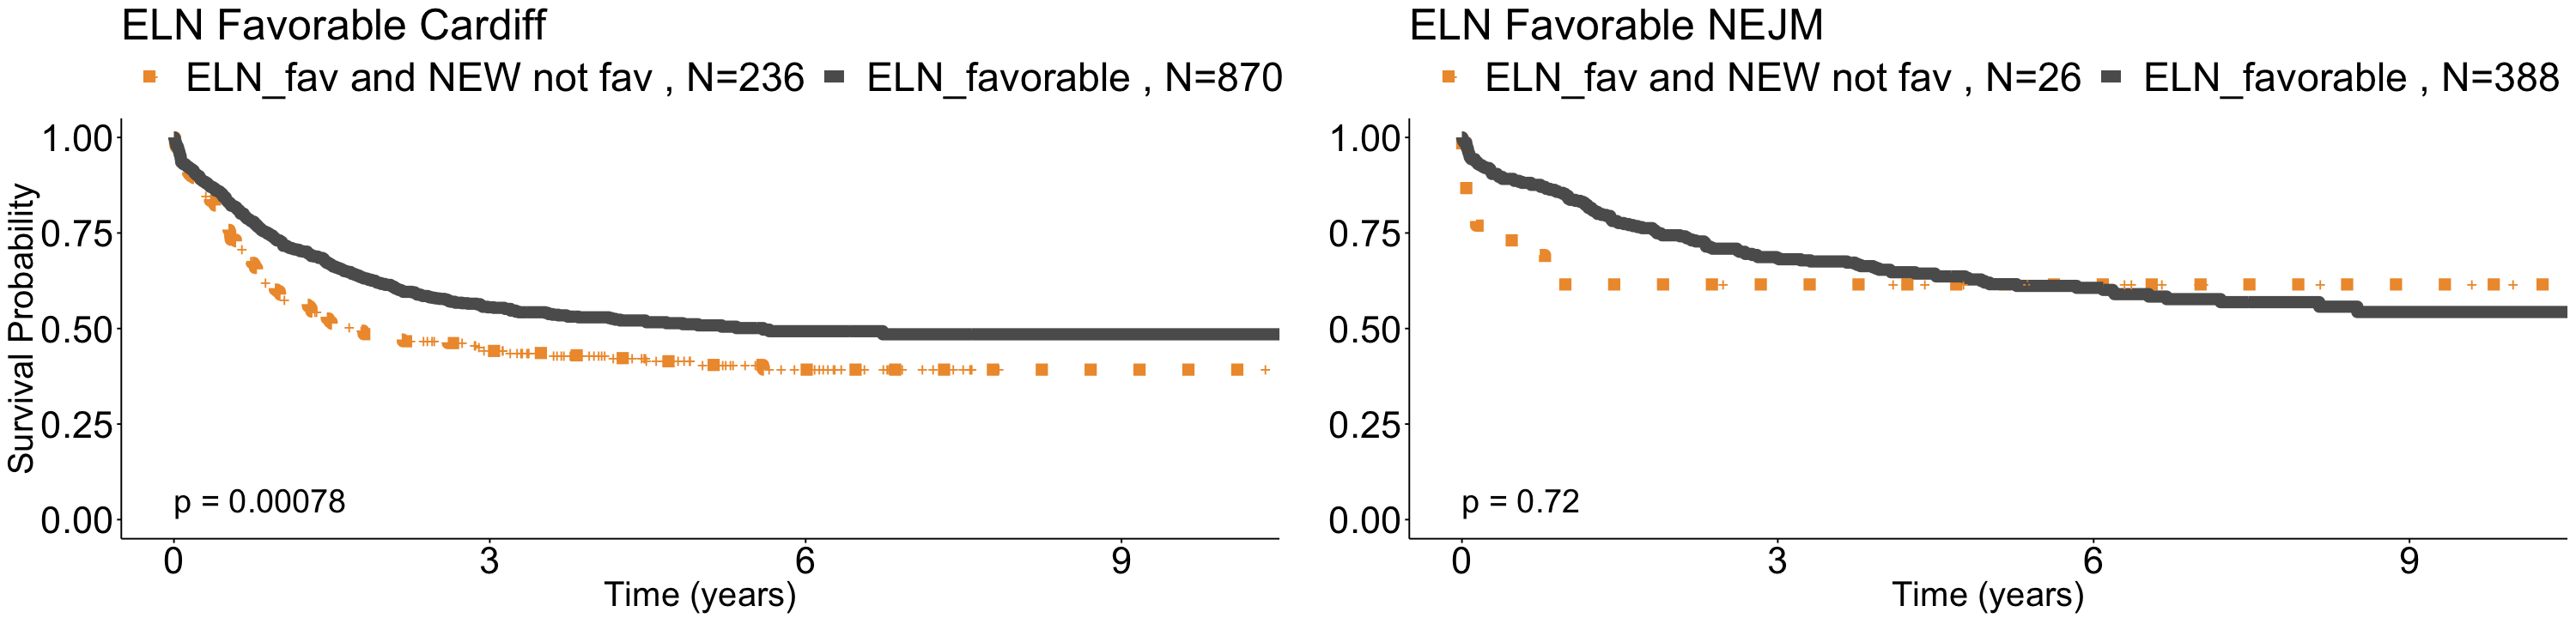

In [361]:
# NEW Intersect
set_notebook_plot_size(25,6)
tmp <- df_final[df_final$eln_2017_favorable!=1 & df_final$molecular_classification=="favorable",]
tmp$comparison <- "NEW_fav and ELN not fav"

tmp1 <- df_final[df_final$molecular_classification=="favorable",]

tmp1$comparison <- paste("NEW",tmp1$molecular_classification,sep="_")
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,linetype=c(3,1),submain="Proposal Favorable Cardiff",xlim=c(0,10),break.time.by=3,y="Survival Probability")

tmp <- df_nejm[df_nejm$eln_2017_favorable!=1 & df_nejm$molecular_classification=="favorable",]
tmp$comparison <- "NEW_fav and ELN not fav"

tmp1 <- df_nejm[df_nejm$molecular_classification=="favorable",]

tmp1$comparison <- paste("NEW",tmp1$molecular_classification,sep="_")
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,linetype=c(3,1,3,1),submain="Proposal Favorable NEJM",xlim=c(0,10),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)

#ELN Intersect

tmp <- df_final[df_final$eln_2017_favorable==1 & df_final$molecular_classification!="favorable",]
tmp$comparison <- "ELN_fav and NEW not fav"

tmp1 <- df_final[df_final$eln_2017_favorable==1,]

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_favorable"))
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,linetype=c(3,1,3,1),submain="ELN Favorable Cardiff",xlim=c(0,10),break.time.by=3,y="Survival Probability")

tmp <- df_nejm[df_nejm$eln_2017_favorable==1 & df_nejm$molecular_classification!="favorable",]
tmp$comparison <- "ELN_fav and NEW not fav"

tmp1 <- df_nejm[df_nejm$eln_2017_favorable==1,]

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_favorable"))
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,linetype=c(3,1,3,1),submain="ELN Favorable NEJM",xlim=c(0,10),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)



In [377]:
tmp <- df_final[df_final$eln_2017_favorable==1 & df_final$molecular_classification!="favorable",]
table(tmp$molecular_classification)
tmp <- colSums(tmp[,comp])
tmp <- t(tmp[tmp!=0])
rownames(tmp) <- "Count"
tmp

tmp <- df_final[df_final$eln_2017_favorable!=1 & df_final$molecular_classification=="favorable",]
table(tmp$eln_2017)
tmp <- colSums(tmp[,comp])
tmp <- t(tmp[tmp!=0])
rownames(tmp) <- "Count"
tmp


     adverse intermediate 
           7          229 

full_component_t_15_17 full_component_inv_16 full_component_t_8_21
Count 6                      1                     4                    
      full_component_t_11 full_component_NPM1 full_component_CEBPA_bi
Count 1                   218                 8                      
      full_component_chr_splicing_multiple overlap
Count 11                                   13


 1  2 
 9 46 

full_component_t_8_21 full_component_t_6_9 full_component_inv_3
Count 3                     1                    1                   
      full_component_TP53_complex full_component_NPM1
Count 6                           6                  
      full_component_chr_splicing_multiple full_component_no_events overlap
Count 1                                    46                       8

# Intermediate

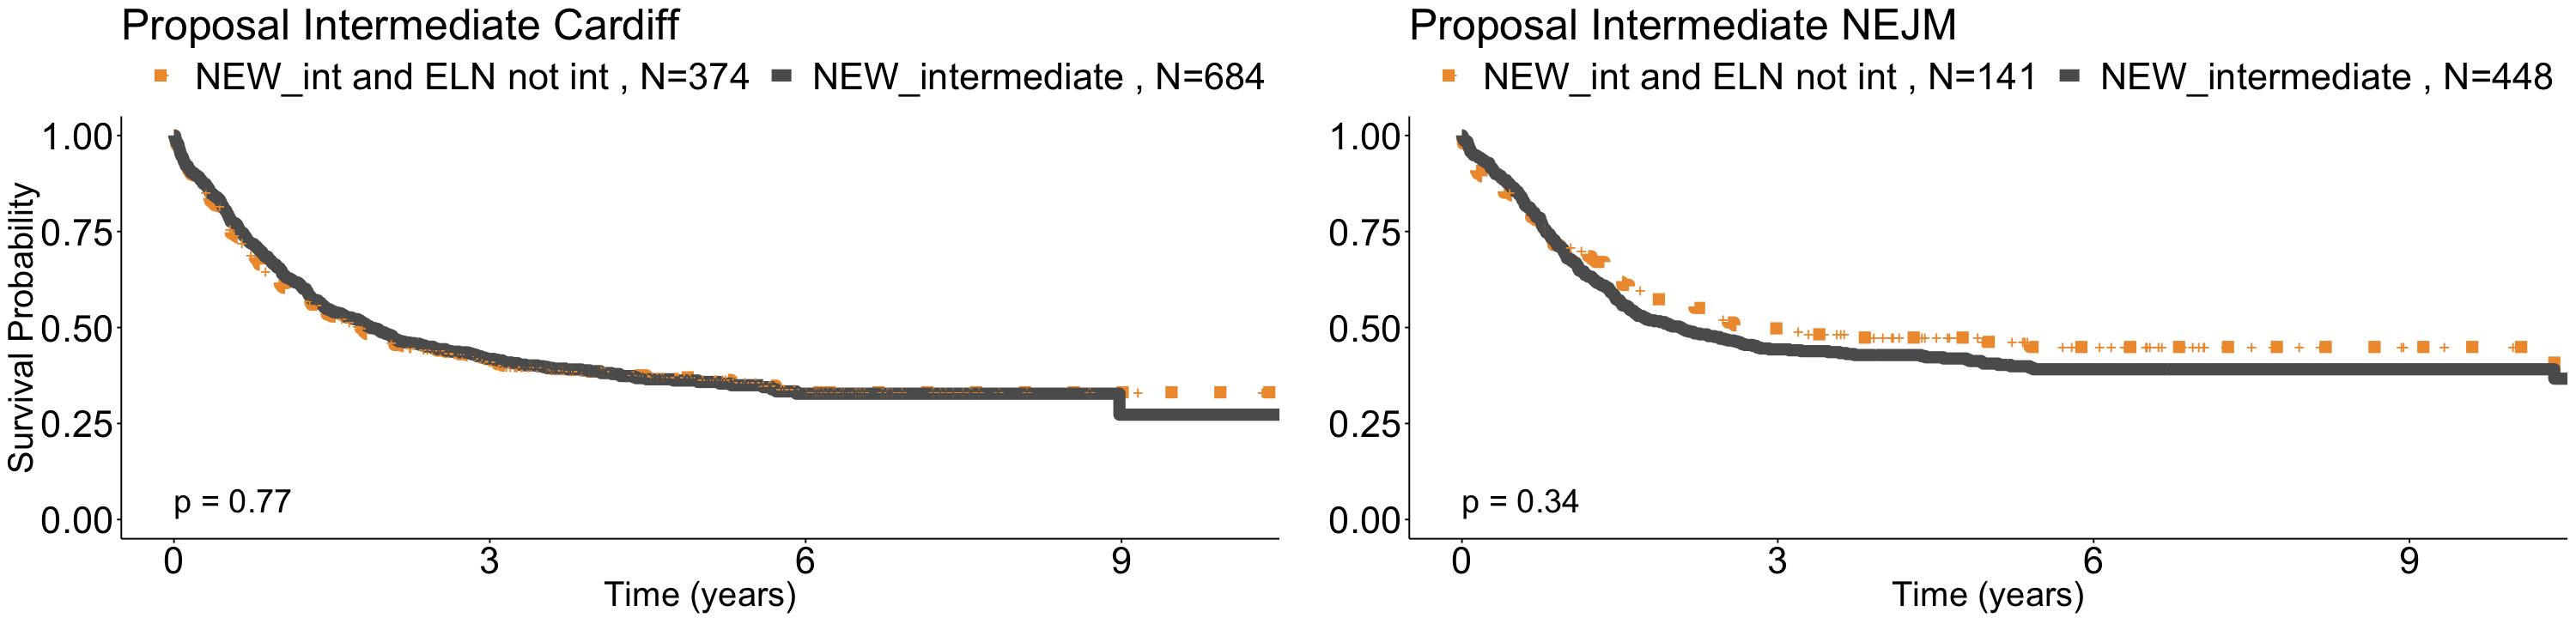

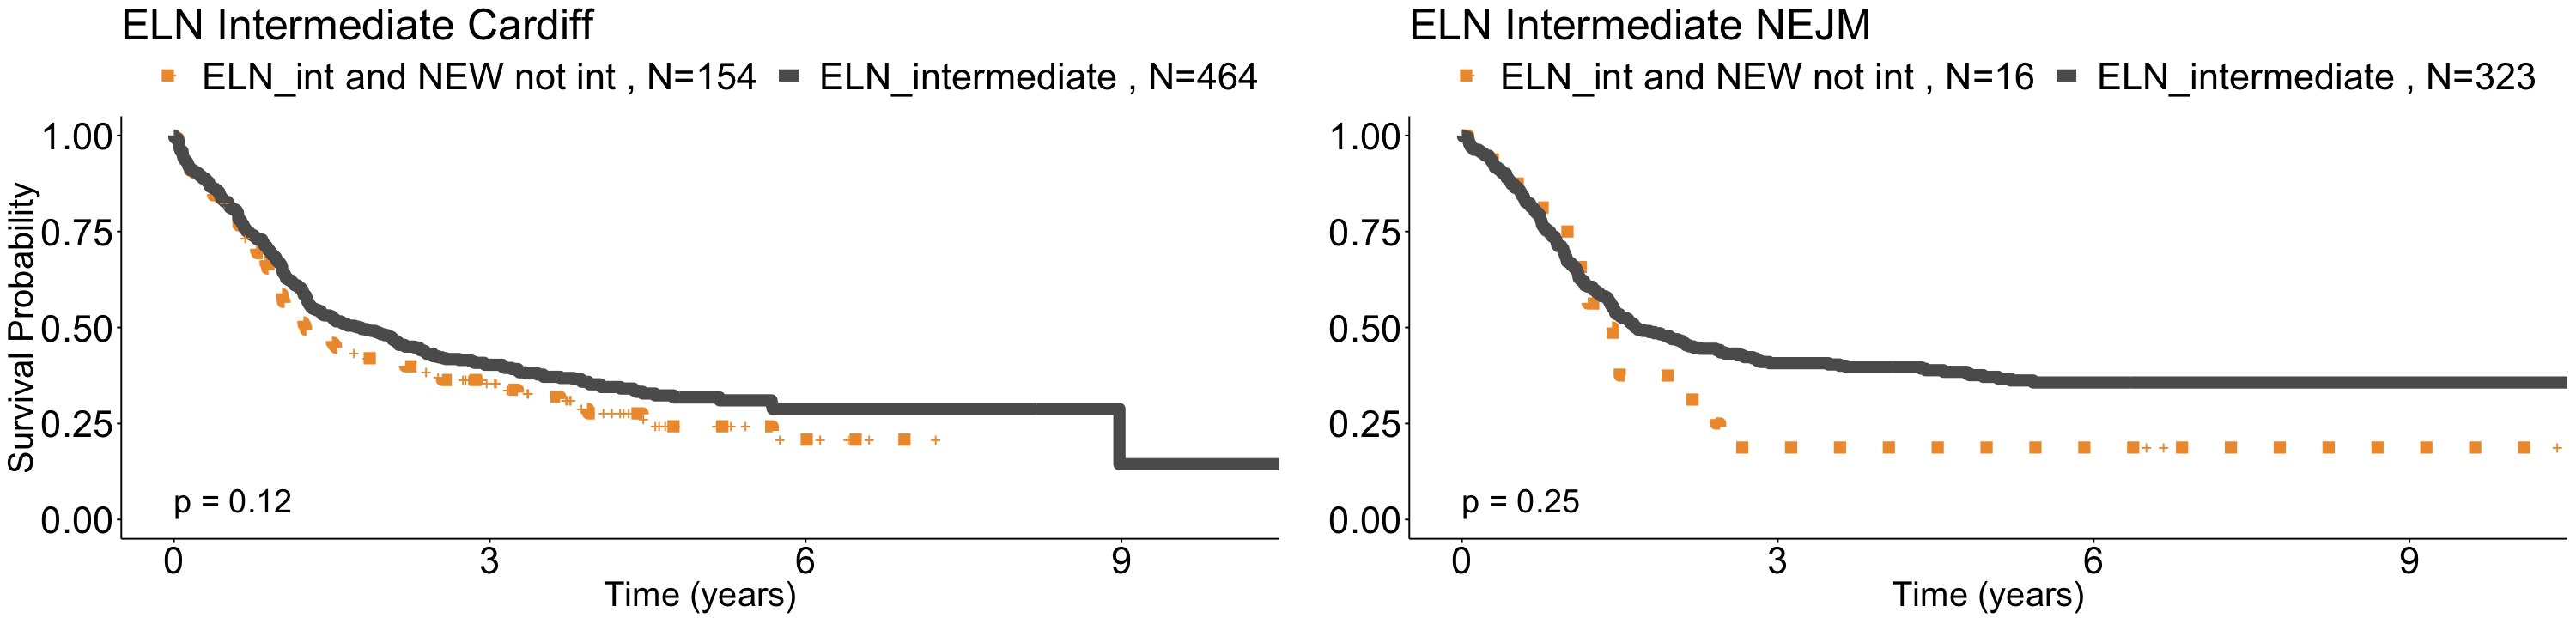

In [374]:
# NEW Intersect
set_notebook_plot_size(25,6)
tmp <- df_final[df_final$eln_2017_intermediate!=1 & df_final$molecular_classification=="intermediate",]
tmp$comparison <- "NEW_int and ELN not int"

tmp1 <- df_final[df_final$molecular_classification=="intermediate",]

tmp1$comparison <- paste("NEW",tmp1$molecular_classification,sep="_")
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,linetype=c(3,1),font.legend=26,submain="Proposal Intermediate Cardiff",
                      xlim=c(0,10),break.time.by=3,y="Survival Probability")

tmp <- df_nejm[df_nejm$eln_2017_intermediate!=1 & df_nejm$molecular_classification=="intermediate",]
tmp$comparison <- "NEW_int and ELN not int"

tmp1 <- df_nejm[df_nejm$molecular_classification=="intermediate",]

tmp1$comparison <- paste("NEW",tmp1$molecular_classification,sep="_")
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,linetype=c(3,1,3,1),font.legend=26,"Proposal Intermediate NEJM",xlim=c(0,10),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)

#ELN Intersect

tmp <- df_final[df_final$eln_2017_intermediate==1 & df_final$molecular_classification!="intermediate",]
tmp$comparison <- "ELN_int and NEW not int"

tmp1 <- df_final[df_final$eln_2017_intermediate==1,]

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_intermediate"))
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,linetype=c(3,1,3,1),font.legend=26,submain="ELN Intermediate Cardiff",
                      xlim=c(0,10),break.time.by=3,y="Survival Probability")

tmp <- df_nejm[df_nejm$eln_2017_intermediate==1 & df_nejm$molecular_classification!="intermediate",]
tmp$comparison <- "ELN_int and NEW not int"

tmp1 <- df_nejm[df_nejm$eln_2017_intermediate==1,]

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_intermediate"))
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,linetype=c(3,1,3,1),font.legend=26,submain="ELN Intermediate NEJM",xlim=c(0,10),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)



In [384]:
tmp <- df_final[df_final$eln_2017_intermediate==1 & df_final$molecular_classification!="intermediate",]
table(tmp$molecular_classification)
table(tmp[tmp$molecular_classification=="adverse",]$ITD)
tmp <- colSums(tmp[,comp])
tmp <- t(tmp[tmp!=0])
rownames(tmp) <- "Count"
tmp

tmp <- df_final[df_final$eln_2017_intermediate!=1 & df_final$molecular_classification=="intermediate",]
table(tmp$eln_2017)
table(tmp[tmp$full_component_chr_splicing_1==1,]$eln_2017)
tmp <- colSums(tmp[,comp])
tmp <- t(tmp[tmp!=0])
rownames(tmp) <- "Count"
tmp


  adverse favorable 
      108        46 


 0  1 
53 55 

full_component_t_11 full_component_additions full_component_TP53_complex
Count 9                   13                       2                          
      full_component_DNMT3A_IDH1_2 full_component_WT1
Count 11                           20                
      full_component_chr_splicing_multiple full_component_chr_splicing_1
Count 55                                   3                            
      full_component_not_assigned full_component_no_events overlap
Count 16                          46                       21


  1   3 
145 229 


 1 
86 

full_component_t_15_17 full_component_inv_16 full_component_t_8_21
Count 6                      1                     4                    
      full_component_t_11 full_component_t_6_9 full_component_additions
Count 12                  5                    14                      
      full_component_TP53_complex full_component_NPM1 full_component_CEBPA_bi
Count 3                           222                 1                      
      full_component_DNMT3A_IDH1_2 full_component_WT1
Count 22                           7                 
      full_component_chr_splicing_multiple full_component_chr_splicing_1
Count 6                                    86                           
      full_component_not_assigned overlap
Count 27                          42

# Adverse

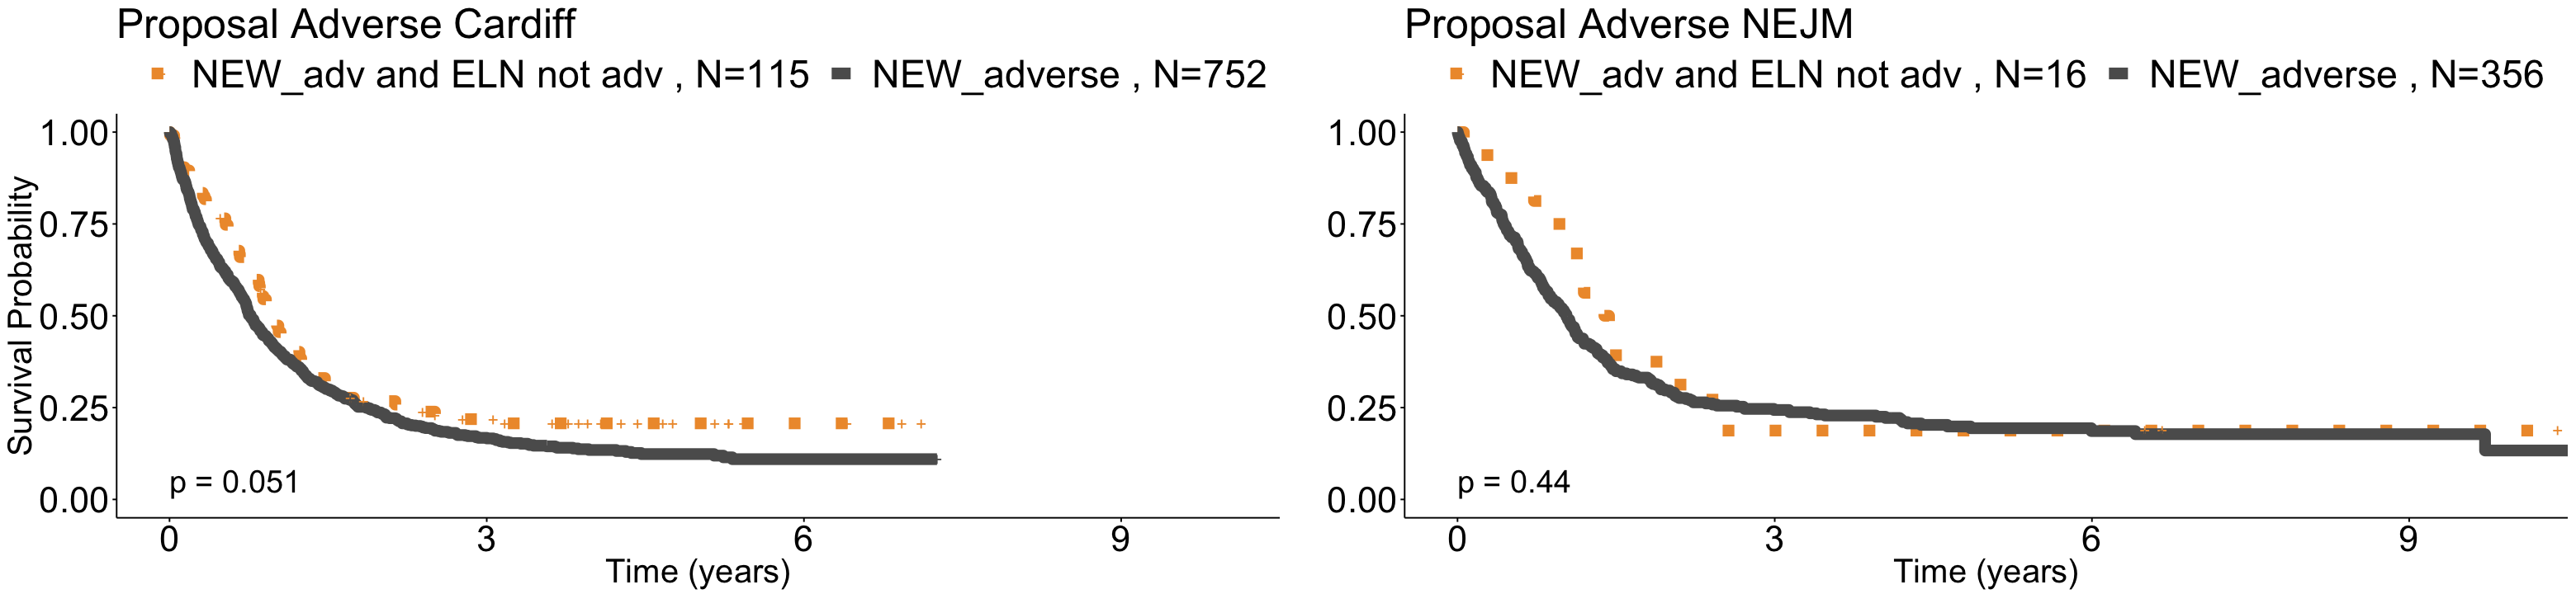

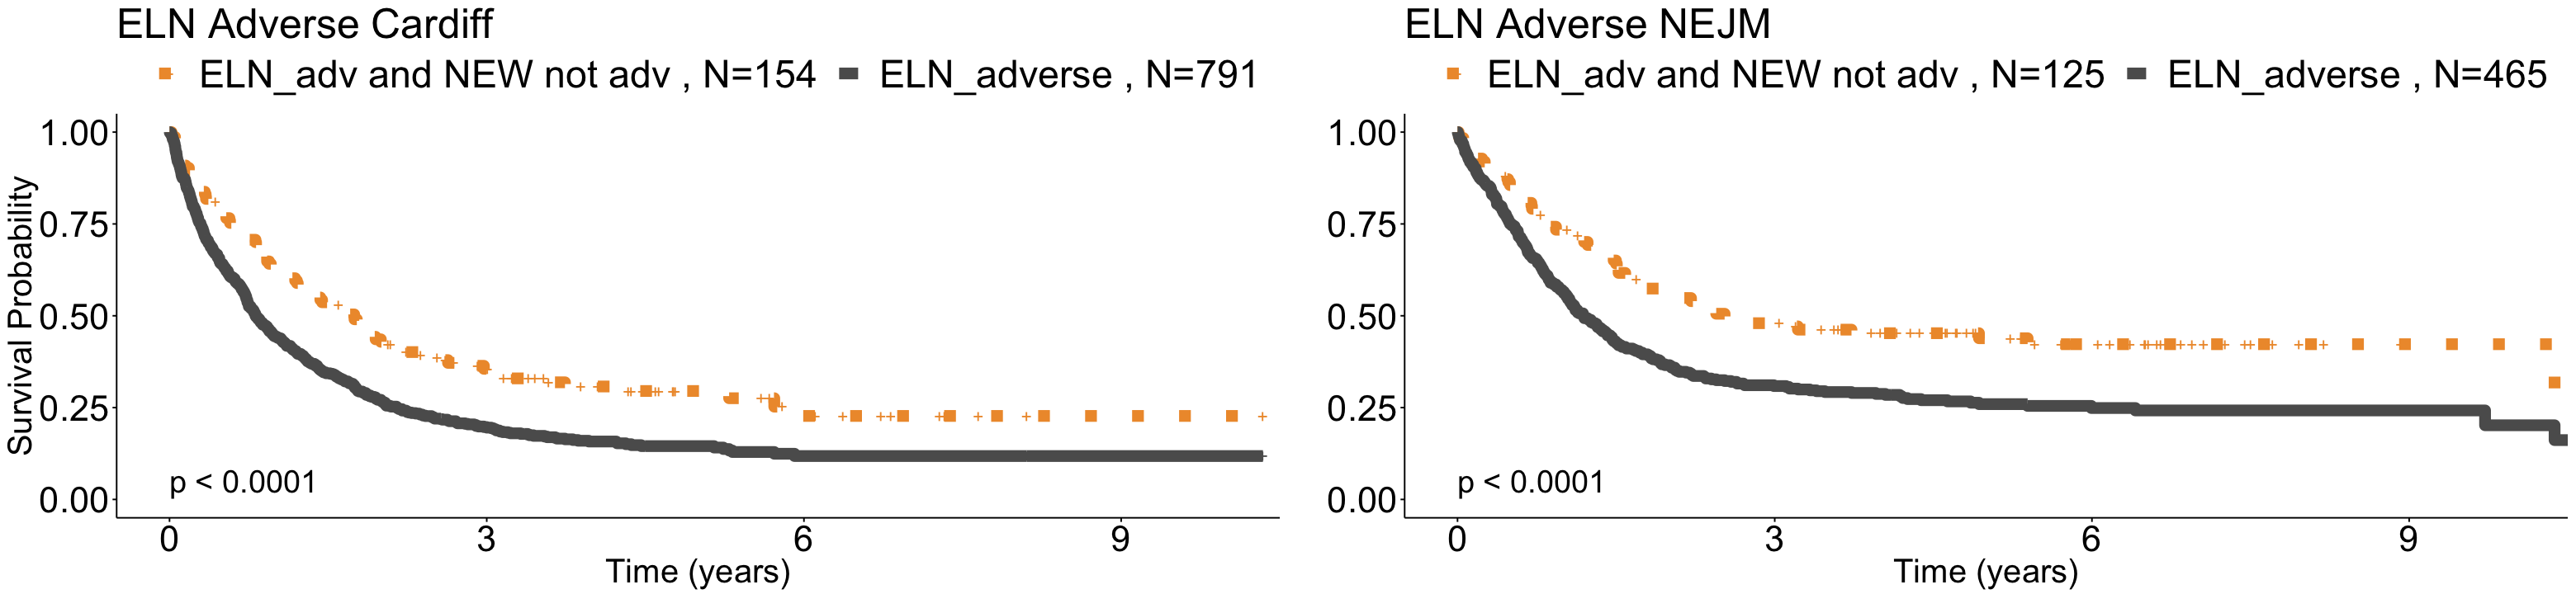

In [386]:
# NEW Intersect
set_notebook_plot_size(26,6)
tmp <- df_final[df_final$eln_2017_adverse!=1 & df_final$molecular_classification=="adverse",]
tmp$comparison <- "NEW_adv and ELN not adv"

tmp1 <- df_final[df_final$molecular_classification=="adverse",]

tmp1$comparison <- paste("NEW",tmp1$molecular_classification,sep="_")
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,linetype=c(3,1),submain="Proposal Adverse Cardiff",xlim=c(0,10),break.time.by=3,y="Survival Probability")

tmp <- df_nejm[df_nejm$eln_2017_adverse!=1 & df_nejm$molecular_classification=="adverse",]
tmp$comparison <- "NEW_adv and ELN not adv"

tmp1 <- df_nejm[df_nejm$molecular_classification=="adverse",]

tmp1$comparison <- paste("NEW",tmp1$molecular_classification,sep="_")
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,linetype=c(3,1,3,1),submain="Proposal Adverse NEJM",xlim=c(0,10),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)

#ELN Intersect

tmp <- df_final[df_final$eln_2017_adverse==1 & df_final$molecular_classification!="adverse",]
tmp$comparison <- "ELN_adv and NEW not adv"

tmp1 <- df_final[df_final$eln_2017_adverse==1,]

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_adverse"))
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,linetype=c(3,1,3,1),submain="ELN Adverse Cardiff",xlim=c(0,10),break.time.by=3,y="Survival Probability")

tmp <- df_nejm[df_nejm$eln_2017_adverse==1 & df_nejm$molecular_classification!="adverse",]
tmp$comparison <- "ELN_adv and NEW not adv"

tmp1 <- df_nejm[df_nejm$eln_2017_adverse==1,]

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_adverse"))
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,linetype=c(3,1,3,1),submain="ELN Adverse NEJM",xlim=c(0,10),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)


In [409]:
tmp <- df_final[df_final$eln_2017_adverse==1 & df_final$molecular_classification!="adverse",]
table(tmp$molecular_classification)
tmp[tmp$full_component_not_assigned==1,c(comp,"ITD","molecular_classification","eln_2017_adverse","t_9_22","GATA2","del_5","complex","RUNX1","ASXL1","del_7","del_17")]
tmp <- colSums(tmp[,comp])
tmp <- t(tmp[tmp!=0])
rownames(tmp) <- "Count"
tmp

tmp <- df_final[df_final$eln_2017_adverse!=1 & df_final$molecular_classification=="adverse",]
tmp <- colSums(tmp[,comp])
tmp <- t(tmp[tmp!=0])
rownames(tmp) <- "Count"
tmp


   favorable intermediate 
           9          145 

full_component_t_15_17 full_component_inv_16 full_component_t_8_21
PD15251a 0                      0                     0                    
PD15474c 0                      0                     0                    
PD19725c 0                      0                     0                    
PD19873a 0                      0                     0                    
PD19879a 0                      0                     0                    
PD19918c 0                      0                     0                    
PD20000a 0                      0                     0                    
PD20198a 0                      0                     0                    
PD20235c 0                      0                     0                    
PD22697c 0                      0                     0                    
PD22731a 0                      0                     0                    
PD22772c 0                      0                     0                    
PD22821c 0                      0                     0                    
PD22868a 0                      0                     0                    
PD22901c 0                      0                     0                    
PD22961a 0                      0                     0                    
PD23097c 0                      0                     0                    
PD23137a 0                      0                     0                    
PD23144a 0                      0                     0                    
PD23151a 0                      0                     0                    
PD23177c 0                      0                     0                    
PD23191a 0                      0                     0                    
PD23317c 0                      0                     0                    
PD25318a 0                      0                     0                    
PD25525a 0                      0                     0                    
PD25535c 0                      0                     0                    
PD25577c 0                      0                     0                    
         full_component_t_11 full_component_t_6_9 full_component_inv_3
PD15251a 0                   0                    0                   
PD15474c 0                   0                    0                   
PD19725c 0                   0                    0                   
PD19873a 0                   0                    0                   
PD19879a 0                   0                    0                   
PD19918c 0                   0                    0                   
PD20000a 0                   0                    0                   
PD20198a 0                   0                    0                   
PD20235c 0                   0                    0                   
PD22697c 0                   0                    0                   
PD22731a 0                   0                    0                   
PD22772c 0                   0                    0                   
PD22821c 0                   0                    0                   
PD22868a 0                   0                    0                   
PD22901c 0                   0                    0                   
PD22961a 0                   0                    0                   
PD23097c 0                   0                    0                   
PD23137a 0                   0                    0                   
PD23144a 0                   0                    0                   
PD23151a 0                   0                    0                   
PD23177c 0                   0                    0                   
PD23191a 0                   0                    0                   
PD23317c 0                   0                    0                   
PD25318a 0                   0                    0                   
PD25525a 0                   0                    0                   
PD25535c 0                   0     

full_component_t_8_21 full_component_t_11 full_component_t_6_9
Count 3                     11                  6                   
      full_component_inv_3 full_component_additions full_component_TP53_complex
Count 1                    14                       9                          
      full_component_NPM1 full_component_DNMT3A_IDH1_2 full_component_WT1
Count 10                  22                           7                 
      full_component_chr_splicing_multiple full_component_chr_splicing_1
Count 3                                    86                           
      full_component_not_assigned overlap
Count 27                          44

full_component_t_11 full_component_additions full_component_TP53_complex
Count 9                   13                       2                          
      full_component_CEBPA_bi full_component_DNMT3A_IDH1_2 full_component_WT1
Count 7                       11                           20                
      full_component_chr_splicing_multiple full_component_chr_splicing_1
Count 62                                   3                            
      full_component_not_assigned overlap
Count 16                          28

# Component introduced in ELN

# Favorable

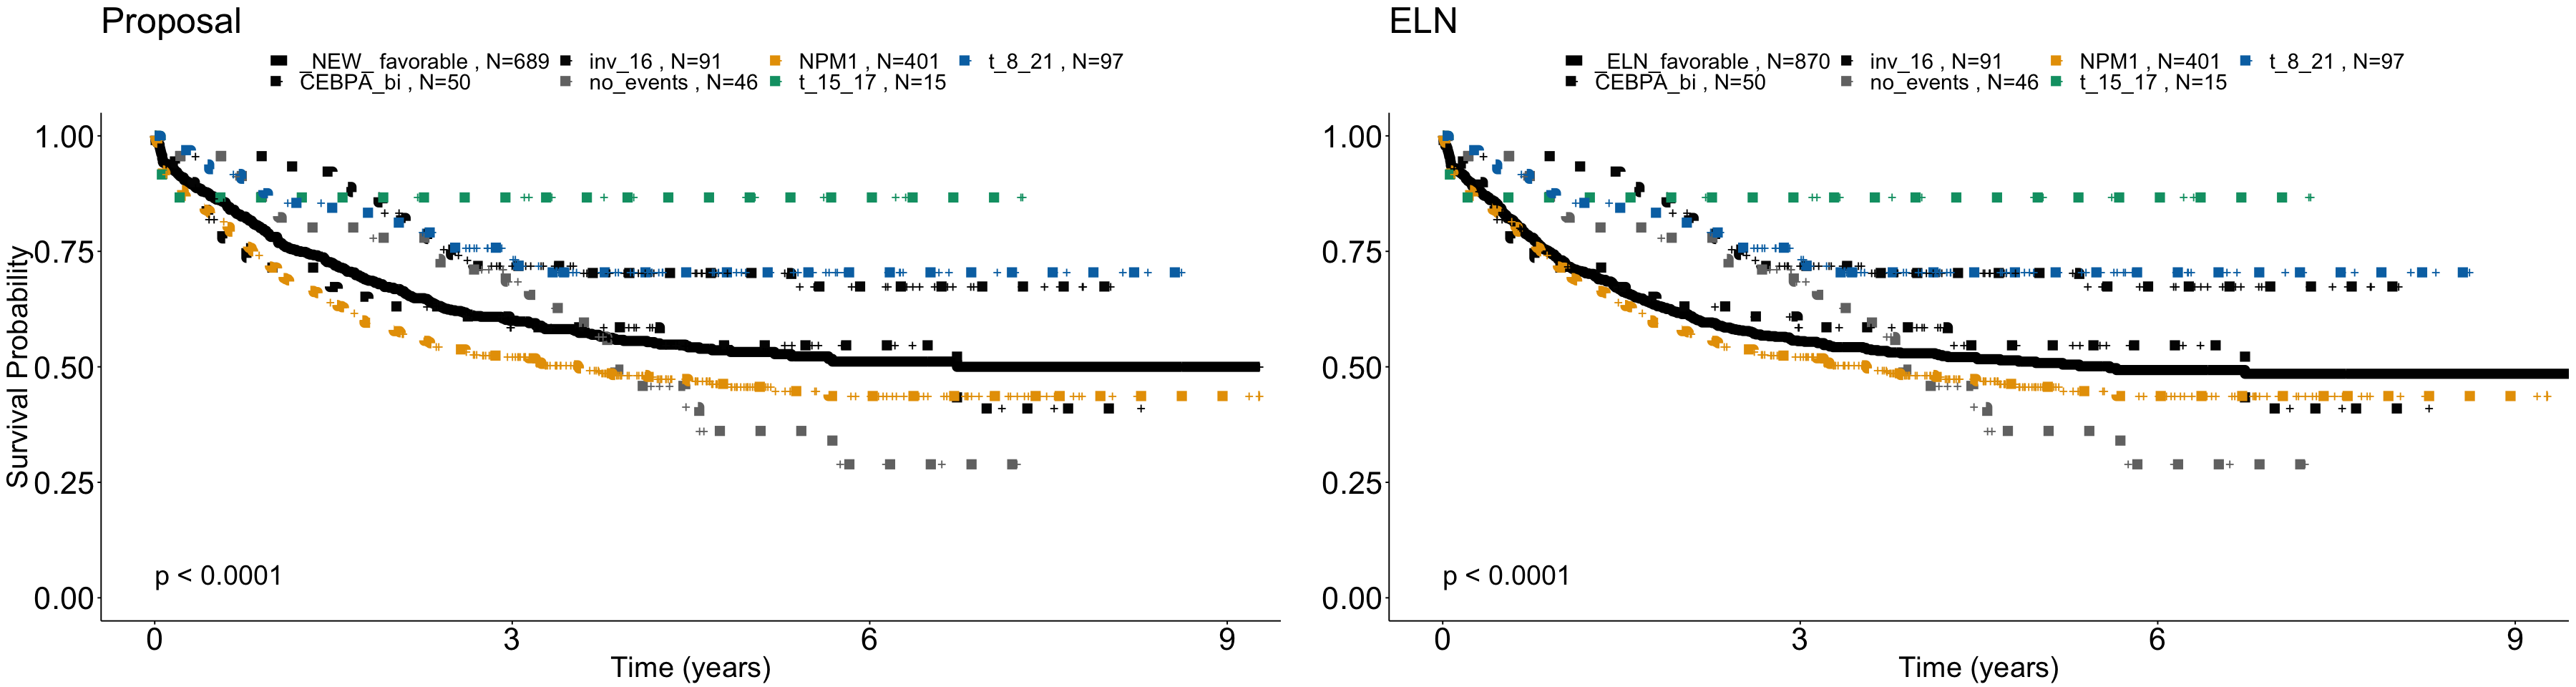

In [418]:
# colors <- as.vector(unlist(color_values))

set_notebook_plot_size(30,8)
for (i in 1:2){
    favorable <- c("full_component_t_15_17","full_component_t_8_21","full_component_inv_16","full_component_CEBPA_bi","full_component_NPM1","full_component_no_events")
    tmp <- NULL
    for (col in favorable){
        tmp1 <- df_final[df_final[,col]==1 & df_final$ITD==0 ,]
        tmp1$comparison <- str_remove(col,"full_component_")
        tmp <- rbind(tmp,tmp1)
        }

    if (i==2){
        tmp1 <- df_final[df_final$eln_2017==3,]

        tmp1$comparison <- ifelse(tmp1$eln_2017==1,"_ELN_adverse",
                                  ifelse(tmp1$eln_2017==2,"_ELN_intermediate","_ELN_favorable"))
    }else{
        tmp1 <- df_final[df_final$molecular_classification=="favorable",]
        tmp1$comparison <-  paste("_NEW_",tmp1$molecular_classification)
    }

    tmp <- rbind(tmp,tmp1)

    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    p[[i]] <- plot_surv_curves(fit,vals=colors,linetype=c(1,rep(3,16)),y=ifelse(i==1,"Survival Probability",""),font.legend=18,submain=ifelse(i==2,"ELN","Proposal"),xlim=c(0,9),break.x.by=3)
}
grid.arrange(p[[1]]$plot,p[[2]]$plot,nrow=1)



# Intermediate

In [425]:
table(df_final$t_6_9,df_final$ITD)

   
       0    1
  0 1666  442
  1    6   11

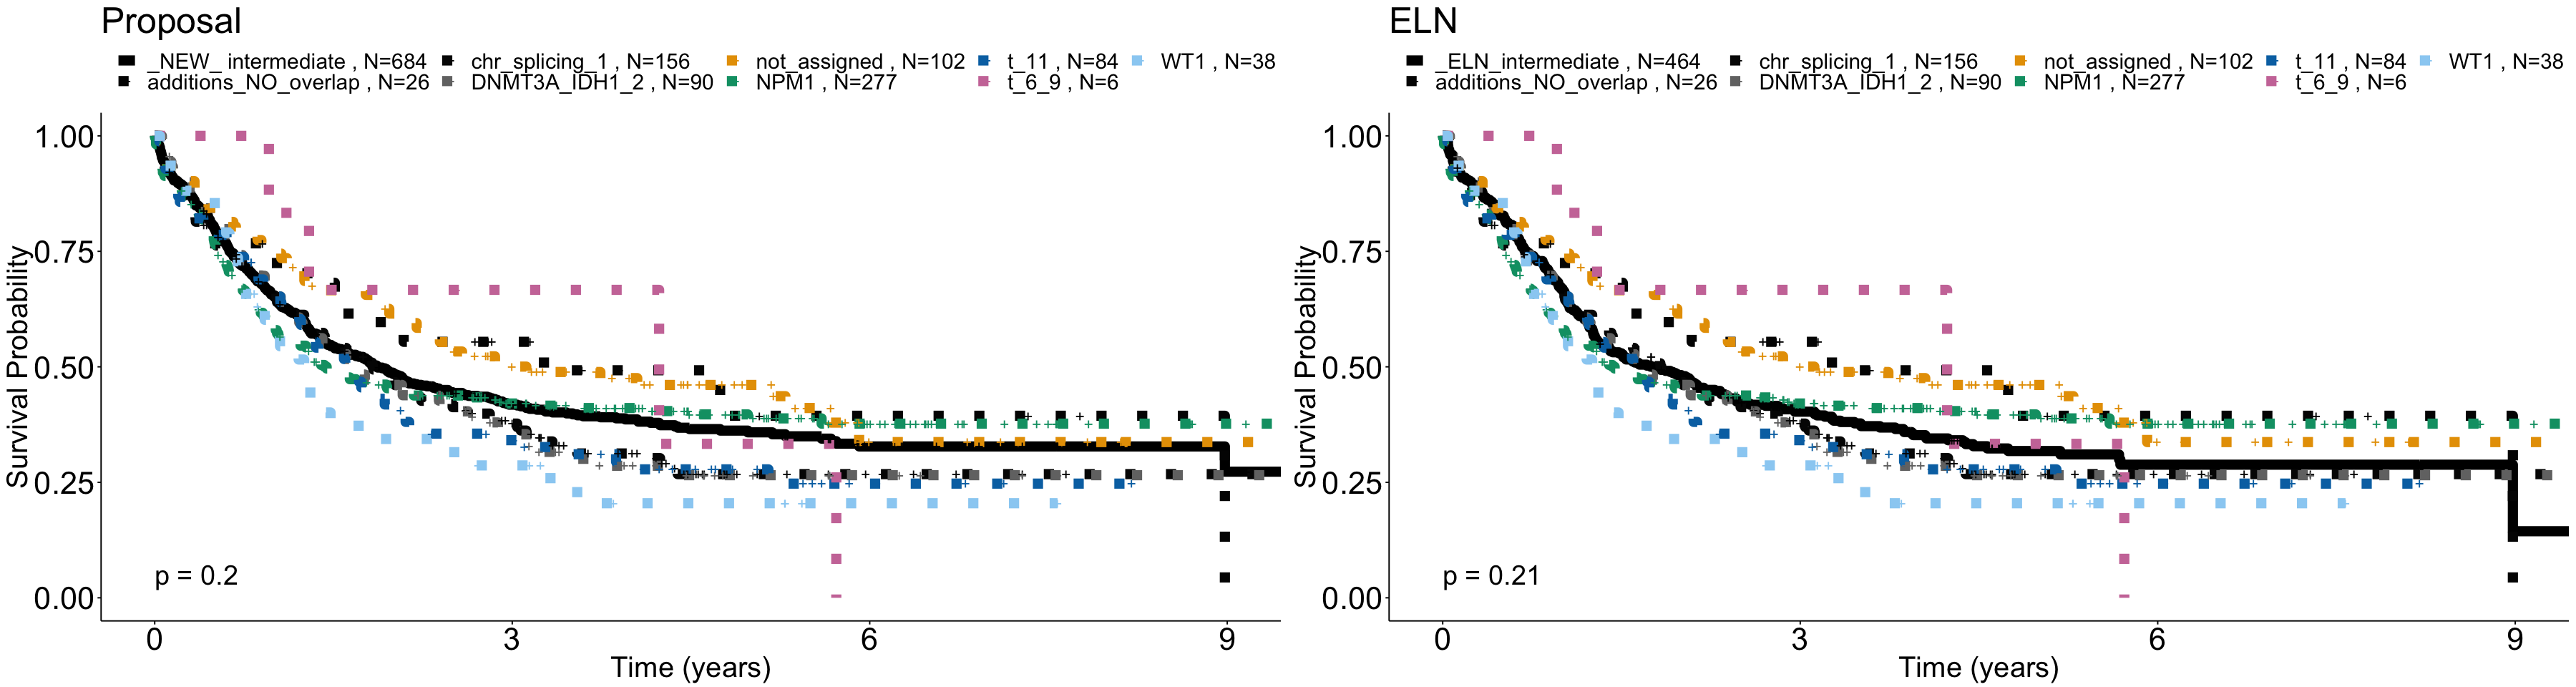

In [434]:
set_notebook_plot_size(30,8)
for (i in 1:2){
    intermediate <- c("full_component_NPM1","full_component_chr_splicing_1","full_component_t_11","full_component_t_6_9","full_component_WT1","full_component_DNMT3A_IDH1_2","full_component_not_assigned","full_component_additions")
    tmp <- NULL
    for (col in intermediate){
        if (col=="full_component_additions"){
            tmp1 <- df_final[df_final[,col]==1 & df_final$overlap==0 & df_final$ITD==0,]
        }else if(col =="full_component_NPM1"){
            tmp1 <- df_final[df_final[,col]==1 & df_final$ITD==1,]
        }else{
            tmp1 <- df_final[df_final[,col]==1 & df_final$ITD==0,]
        }
        tmp1$comparison <- ifelse(col=="full_component_additions","additions_NO_overlap",str_remove(col,"full_component_"))
        tmp <- rbind(tmp,tmp1)
        }

    if (i==2){
        tmp1 <- df_final[df_final$eln_2017==2,]

        tmp1$comparison <- ifelse(tmp1$eln_2017==1,"_ELN_adverse",
                                  ifelse(tmp1$eln_2017==2,"_ELN_intermediate","_ELN_favorable"))
    }else{
        tmp1 <- df_final[df_final$molecular_classification=="intermediate",]
        tmp1$comparison <-  paste("_NEW_",tmp1$molecular_classification)
    }

    tmp <- rbind(tmp,tmp1)

    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    p[[i]] <- plot_surv_curves(fit,vals=colors,linetype=c(1,rep(3,16)),y="Survival Probability",font.legend=18,submain=ifelse(i==2,"ELN","Proposal"),xlim=c(0,9),break.x.by=3)
}
grid.arrange(p[[1]]$plot,p[[2]]$plot,nrow=1)


# Adverse

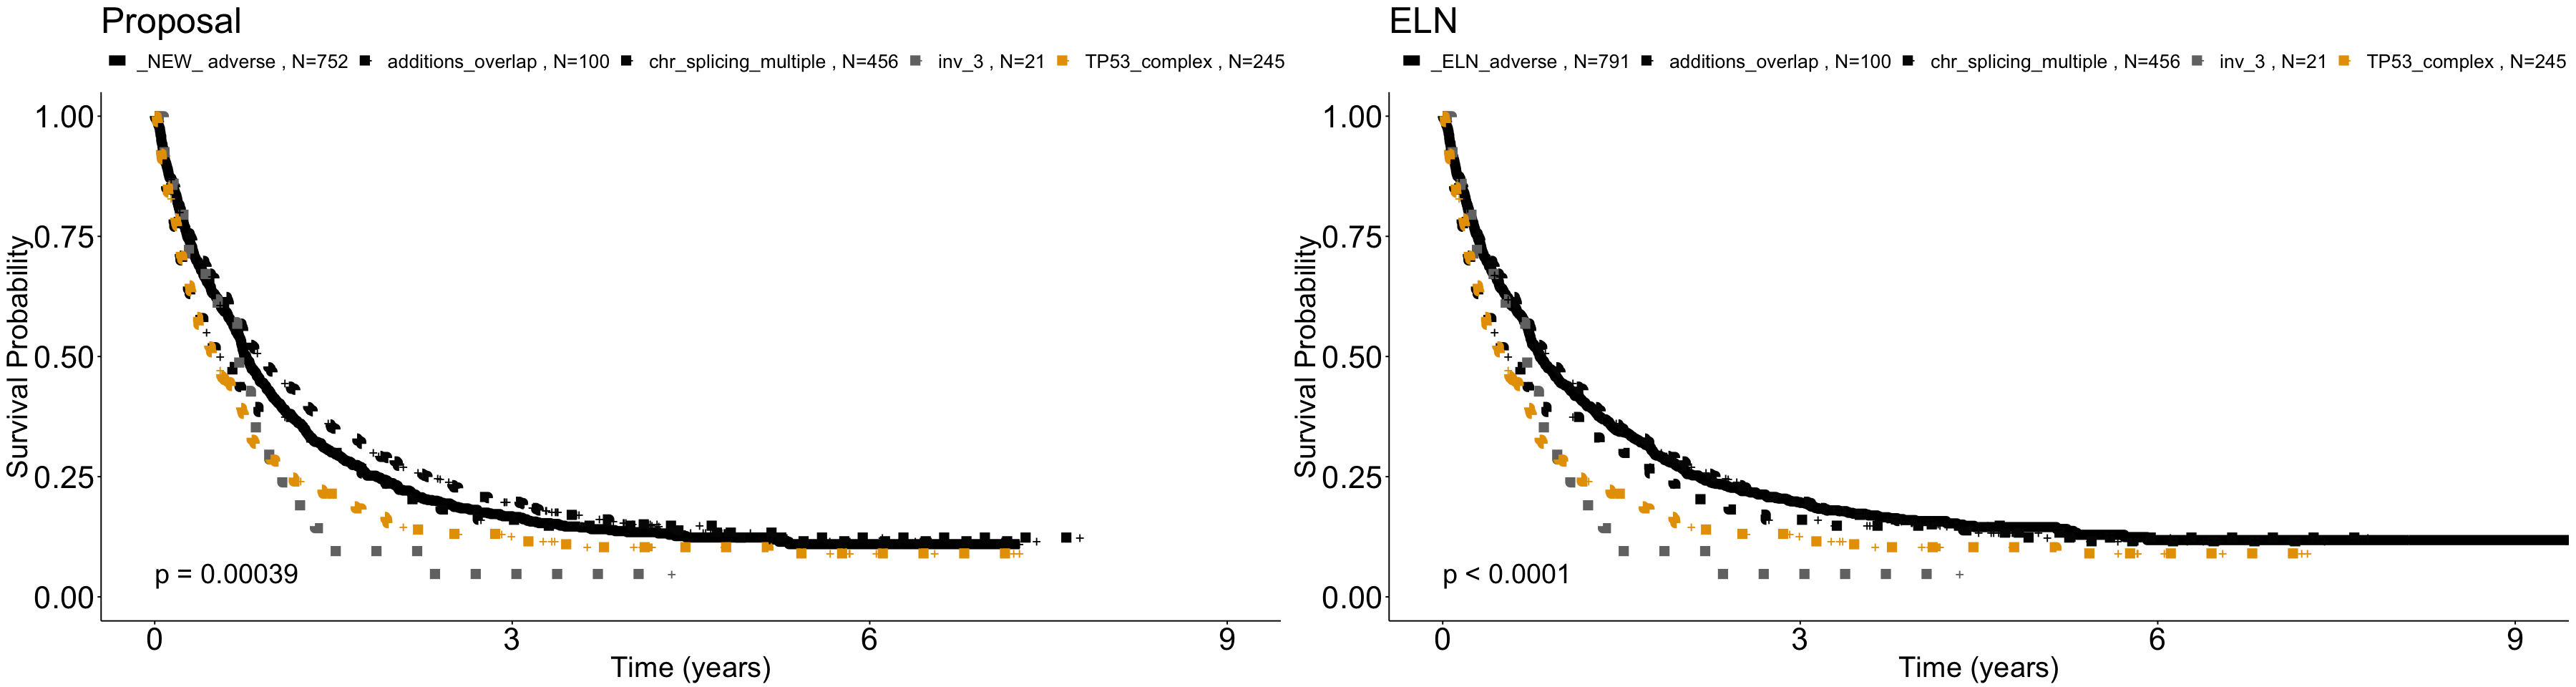

In [436]:
set_notebook_plot_size(30,8)
for (i in 1:2){
    adverse <- c("full_component_chr_splicing_multiple","full_component_additions","full_component_TP53_complex","full_component_inv_3")
    tmp <- NULL
    for (col in adverse){
        if(col=="full_component_additions"){
            tmp1 <- df_final[df_final[,col]==1 & tmp$overlap==1,]
        }else{
            tmp1 <- df_final[df_final[,col]==1,]
        }
        tmp1$comparison <- ifelse(col=="full_component_additions","additions_overlap",str_remove(col,"full_component_"))
        tmp <- rbind(tmp,tmp1)
        }

    if (i==2){
        tmp1 <- df_final[df_final$eln_2017==1,]

        tmp1$comparison <- ifelse(tmp1$eln_2017==1,"_ELN_adverse",
                                  ifelse(tmp1$eln_2017==2,"_ELN_intermediate","_ELN_favorable"))
    }else{
        tmp1 <- df_final[df_final$molecular_classification=="adverse",]
        tmp1$comparison <-  paste("_NEW_",tmp1$molecular_classification)
    }

    tmp <- rbind(tmp,tmp1)

    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    p[[i]] <- plot_surv_curves(fit,vals=colors,linetype=c(1,rep(3,16)),y="Survival Probability",font.legend=16,submain=ifelse(i==2,"ELN","Proposal"),xlim=c(0,9),break.x.by=3)
}
grid.arrange(p[[1]]$plot,p[[2]]$plot,nrow=1)

# Variance Captured by ELN vs by Proposal

In [488]:

df_summary <- data.frame(Dataset=c(rep("Cardiff",2),rep("Nejm",2)),Model=rep(c("Proposal","ELN"),2),R_squared=0,Concordance=0)
df_summary[1,c("R_squared","Concordance")] <- c(summary(coxph(Surv(os,os_status)~molecular_classification,df_final))$rsq[[1]],summary(coxph(Surv(os,os_status)~molecular_classification,df_final))$concordance[[1]])
df_summary[2,c("R_squared","Concordance")] <- c(summary(coxph(Surv(os,os_status)~eln_2017,df_final))$rsq[[1]],summary(coxph(Surv(os,os_status)~eln_2017,df_final))$concordance[[1]])
df_summary[3,c("R_squared","Concordance")] <- c(summary(coxph(Surv(OS,OS_Status)~molecular_classification,df_nejm))$rsq[[1]],summary(coxph(Surv(OS,OS_Status)~molecular_classification,df_nejm))$concordance[[1]])
df_summary[4,c("R_squared","Concordance")] <- c(summary(coxph(Surv(OS,OS_Status)~eln_2017,df_nejm))$rsq[[1]],summary(coxph(Surv(OS,OS_Status)~eln_2017,df_nejm))$concordance[[1]])

In [485]:
c(summary(coxph(Surv(os,os_status)~molecular_classification,df_final))$rsq[[1]],summary(coxph(Surv(os,os_status)~molecular_classification,df_final))$concordance[[1]])

[1] 0.1456747 0.6309860

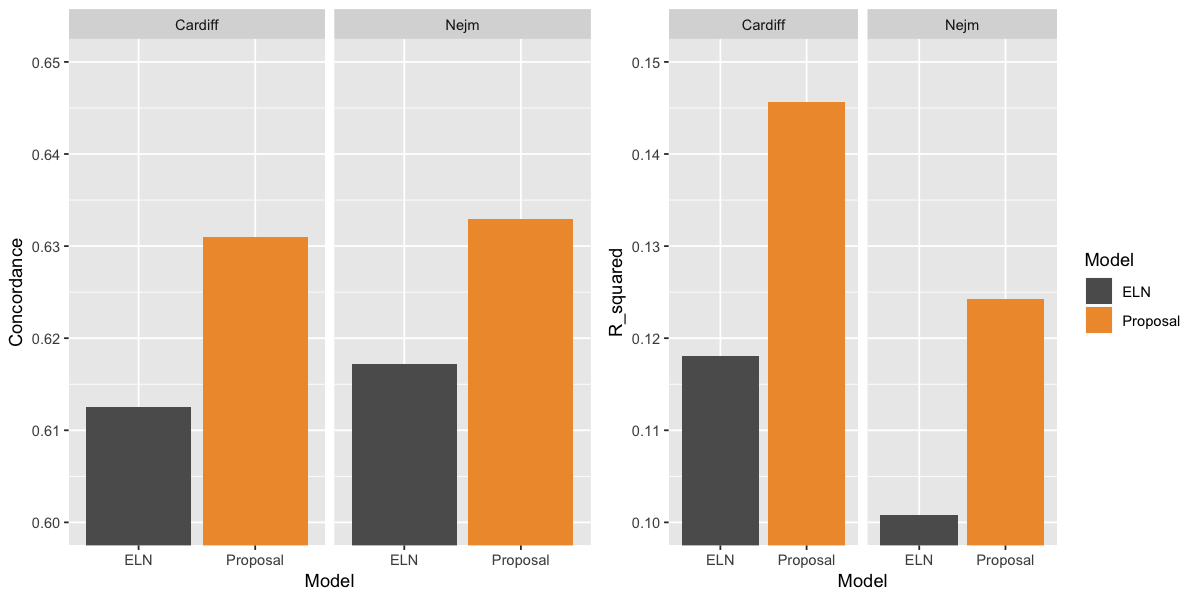

In [525]:
set_notebook_plot_size(10,5)
p <- ggplot(df_summary,aes(x=Model,y=Concordance,fill=Model))+coord_cartesian(ylim=c(0.6,0.65))+geom_bar(stat="identity")+facet_wrap(~Dataset)+scale_fill_manual(values = c("#5C5C5C","#EE9937"))+theme(legend.position = "none")
q <- ggplot(df_summary,aes(x=Model,y=R_squared,fill=Model))+coord_cartesian(ylim=c(0.1,0.15))+geom_bar(stat="identity")+facet_wrap(~Dataset)+scale_fill_manual(values = c("#5C5C5C","#EE9937"))
grid.arrange(p,q,nrow=1)
# ggplot(df_summary,aes(x=Model,y=Concordance))+geom_bar(stat="identity")+coord_flip()

In [482]:
df_summary

Dataset Model    R_squared Concordance
1 Cardiff Proposal 0         0          
2 Cardiff ELN      0         0          
3 Nejm    Proposal 0         0          
4 Nejm    ELN      0         0